# Paper figures

In [1]:
import utils
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from skimage import measure
from scipy.stats import permutation_test, norm
from statsmodels.stats.multitest import multipletests
from nilearn.plotting import plot_markers
from util.ise import ROIS, ALL_ROIs, getMaps
from util.stats import (
    mean_diff_axis,
    calculate_pvalues,
    permute_differences,
    cdf_pvalues,
    # cdf_pvals2,
)
from util.path import derivpath
from util.plot import formatenc, formatim
from utils import load_pickle

plt.style.use("presentation.mplstyle")
colors = sns.color_palette()
RED, BLUE = colors[3], colors[0]
YELLOW, GRAY = "goldenrod", colors[7]  # goldenrod: 218., 165.,  32.
RED_CMAP = sns.light_palette(RED, as_cmap=True)
BLUE_CMAP = sns.light_palette(BLUE, as_cmap=True)
fs1c = (2.24, 2.24 / (4 / 3))
fs2c = (4.76, 4.76 / (4 / 3))
fs3c = (7.24, 7.24 / (4 / 3))
gr = 1 - np.sqrt(5) / 2 + 0.5

In [2]:
# Options
root = "../dataset/derivatives/encoding/"
Ss = [1, 2, 3, 4, 5, 6, 9, 10, 11, 12]
modes = ["prod", "comp"]

tmax, window, jump = 4, 0.250, 0.03125 * 2
lags = np.arange(-tmax, tmax + jump, jump)

rois = list(ROIS.keys())

models = []
# models.append('model-llama-7b_maxlen-1024_layer-16_reg-l2')
# models.append('model-bert-large-wwm_layer-12_reg-l2')  # actual bert
# models.append('model-random_ndim-1600_reg-l2')  # random embeddings
# models.append('model-gpt2-xl_maxlen-0_reg-l2')  # static gpt2
# models.append("model-gpt2-xl_maxlen-1024_layer-24_random_reg-l2")  # untrained gpt2
# models.append('model-glove-300_reg-l2')  # glove
# models.append('model-symbolic_reg-l2')  # symbolic
# models.append('model-phonetic_reg-l2')  # articulatory
# models.append('model-whisper-tiny_reg-l2')  # whisper
models.append("model-gpt2-xl_maxlen-1024_layer-24_reg-l2")  # actual gpt2

# model-gpt2-xl_maxlen-64_layer-24_reg-l2/sub-01_task-conversation_encoding_mode-prod_band-highgamma.pkl
# model-gpt2-xl_maxlen-1024_layer-24_reg-l2/sub-01_task-conversation_encoding_mode-prod_band-highgamma_nfolds-2.pkl

modelname = models[-1]
parts = utils.getparts(modelname)
shortname = "_".join(map(str, list(parts.values())[:4]))

print(modelname, shortname)

model-gpt2-xl_maxlen-1024_layer-24_reg-l2 gpt2-xl_1024_24_l2


In [3]:
root = "../dataset/derivatives/encoding_bands/"  # banded ridge regression
# root = "../dataset/derivatives/encoding/"

# Load data

In [4]:
method, alpha = "fdr_bh", 0.01
datatype = f"method-{method}_alpha-{alpha}_lags-1"
sigmodelname = "model-gpt2-xl_maxlen-0_reg-l2_perm-phase"
p = derivpath(
    f"sub-all_model-{sigmodelname}.pkl",
    derivative="electrode-selection",
    datatype=datatype,
)
sigmasks = load_pickle(p)
sigmasks = {key[:2]: value for key, value in sigmasks.items()}
nsig_elecs = sum([s.sum() for s in sigmasks.values()])
nsig_elecs, sigmasks.keys()

(384,
 dict_keys([(1, 'prod'), (1, 'comp'), (2, 'prod'), (2, 'comp'), (3, 'prod'), (3, 'comp'), (4, 'prod'), (4, 'comp'), (5, 'prod'), (5, 'comp'), (6, 'prod'), (6, 'comp'), (9, 'prod'), (9, 'comp'), (10, 'prod'), (10, 'comp'), (11, 'prod'), (11, 'comp'), (12, 'prod'), (12, 'comp')]))

In [5]:
band = "highgamma"
# outdir = f'../results/paper/{sigmodelname}_method-{method}_alpha-{alpha}/{band}/{modelname}'
outdir = f"../results/paper/{sigmodelname}_method-{method}_alpha-{alpha}/{modelname}"
!mkdir -p {outdir}
outdir

'../results/paper/model-gpt2-xl_maxlen-0_reg-l2_perm-phase_method-fdr_bh_alpha-0.01/model-gpt2-xl_maxlen-1024_layer-24_reg-l2'

In [7]:
# Load actual results
import gc

results = {}
for sub in Ss:
    for mode in modes:
        for mname in models:
            # actual_pickle = glob.glob(
            #     f"{root}sub-{sub:02d}/{mname}/sub-{sub:02d}_task-conversation_encoding_mode-{mode}.pkl"
            # )

            # after adding band in filename
            # actual_pickle = glob.glob(
            #     f"{root}sub-{sub:02d}/{mname}/sub-{sub:02d}_task-conversation_encoding_mode-{mode}_band-{band}.pkl"
            # )

            # 2 fold:
            # actual_pickle = glob.glob(f'{root}sub-{sub:02d}/{mname}/sub-{sub:02d}_task-conversation_encoding_mode-{mode}_band-{band}_nfolds-2.pkl')

            # banded ridge:
            actual_pickle = glob.glob(
                f"{root}sub-{sub:02d}/{mname}/sub-{sub:02d}_task-conversation_encoding_bands_mode-{mode}_band-{band}_nfolds-10.pkl"
            )
            if len(actual_pickle):
                print(sub, mode, mname)
                with open(actual_pickle[0], "rb") as f:
                    result = pickle.load(f)
                    # For encoding
                    # del result['embs']
                    # del result['df']
                    del result["args"]
                    # del result["coefs"]
                    # del result["preds"]
                    # del result["true"]
                    results[(sub, mode, mname)] = result
                    gc.collect()
# print(result.keys())
# results.keys()
len(results)

1 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
1 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
2 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
2 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
3 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
3 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
4 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
4 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
5 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
5 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
6 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
6 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
9 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
9 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
10 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
10 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
11 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
11 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
12 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
12 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2


20

In [9]:
allcoords = utils.getallcoords(results, Ss, modelname)

Opening raw data file ../dataset/derivatives/preprocessed/sub-01/fastica/sub-01_task-conversation_desc-highgamma_ieeg.fif...
    Range : 0 ... 842751 =      0.000 ...  1645.998 secs
Ready.
Opening raw data file ../dataset/derivatives/preprocessed/sub-02/fastica/sub-02_task-conversation_desc-highgamma_ieeg.fif...
    Range : 0 ... 842751 =      0.000 ...  1645.998 secs
Ready.
Opening raw data file ../dataset/derivatives/preprocessed/sub-03/fastica/sub-03_task-conversation_desc-highgamma_ieeg.fif...
    Range : 0 ... 773119 =      0.000 ...  1509.998 secs
Ready.
Opening raw data file ../dataset/derivatives/preprocessed/sub-04/fastica/sub-04_task-conversation_desc-highgamma_ieeg.fif...
    Range : 0 ... 714239 =      0.000 ...  1394.998 secs
Ready.
Opening raw data file ../dataset/derivatives/preprocessed/sub-05/fastica/sub-05_task-conversation_desc-highgamma_ieeg.fif...
    Range : 0 ... 795647 =      0.000 ...  1553.998 secs
Ready.
Opening raw data file ../dataset/derivatives/preprocess

## new sig test

In [24]:
def get_null_dist(size, iters=10000, seed=None):
    rng = np.random.default_rng(seed=seed)
    null_dist = np.zeros(iters)
    for i in range(iters):
        a = rng.normal(size=size)
        b = rng.normal(size=size)
        null_dist[i] = np.corrcoef(a, b)[0, 1]
    return null_dist

In [55]:
all_elecs = 0
total_sig = 0
newsigmasks = {}
for key, result in results.items():
    n_test = int(np.mean([len(r) for r in result["true"]]))
    corrs = np.stack(result["corrs"]).mean(0)

    null_dist = get_null_dist(size=int(n_test), seed=42)

    observed = corrs.max(-1)
    pvals = [calculate_pvalues(obs, null_dist) for obs in observed]
    reject, pvals_corr, _, _ = multipletests(pvals, method="fdr_bh")
    print(key[:2], n_test, corrs.shape, reject.sum())
    total_sig += reject.sum()

    newsigmasks[key[:2]] = reject

total_sig  # 371

(1, 'prod') 101 (88, 129) 2
(1, 'comp') 237 (88, 129) 14
(2, 'prod') 237 (78, 129) 36
(2, 'comp') 101 (78, 129) 6
(3, 'prod') 149 (88, 129) 2
(3, 'comp') 128 (88, 129) 0
(4, 'prod') 128 (104, 129) 35
(4, 'comp') 149 (104, 129) 27
(5, 'prod') 27 (83, 129) 0
(5, 'comp') 246 (83, 129) 19
(6, 'prod') 246 (98, 129) 20
(6, 'comp') 27 (98, 129) 0
(9, 'prod') 210 (98, 129) 13
(9, 'comp') 97 (98, 129) 17
(10, 'prod') 97 (54, 129) 28
(10, 'comp') 210 (54, 129) 41
(11, 'prod') 434 (108, 129) 83
(11, 'comp') 105 (108, 129) 9
(12, 'prod') 105 (89, 129) 2
(12, 'comp') 434 (89, 129) 17


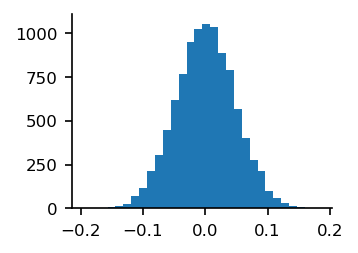

In [81]:
plt.hist(null_dist, bins=30)

In [83]:
all_elecs = 0
tot_old, tot_new = 0, 0
both, only_old, only_new = 0, 0, 0
for key in sigmasks.keys():
    original = sigmasks[key]
    new = newsigmasks[key]
    both += (original & new).sum()
    only_old += (original & (~new)).sum()
    only_new += ((~original) & new).sum()
    print(key, both, only_old, only_new)
    tot_old += original.sum()
    tot_new += new.sum()
    all_elecs += original.size

print(tot_old, tot_new, all_elecs)
print(both / min(tot_old, tot_new))

(1, 'prod') 2 9 0
(1, 'comp') 11 12 5
(2, 'prod') 40 19 12
(2, 'comp') 46 21 12
(3, 'prod') 48 26 12
(3, 'comp') 48 52 12
(4, 'prod') 76 61 19
(4, 'comp') 92 64 30
(5, 'prod') 92 69 30
(5, 'comp') 98 72 43
(6, 'prod') 117 75 44
(6, 'comp') 117 77 44
(9, 'prod') 124 83 50
(9, 'comp') 141 97 50
(10, 'prod') 158 99 61
(10, 'comp') 178 99 82
(11, 'prod') 238 101 105
(11, 'comp') 247 112 105
(12, 'prod') 249 124 105
(12, 'comp') 258 126 113
384 371 1776
0.6954177897574124


# surface plotting

In [45]:
coords, values = [], []
lag = 129 // 2
mode = "prod"
for sub in Ss:
    corrs = np.mean(results[(sub, mode, modelname)]["corrs"], axis=0)[:, lag]
    mask = sigmasks[(sub, mode)]
    # mask = None
    coords.append(allcoords[sub][mask].squeeze())
    values.append(corrs[mask].squeeze())
coords = np.concatenate(coords)
values = np.concatenate(values)
coords.shape, values.shape

((226, 3), (226,))

In [7]:
from scipy.io import loadmat
import plotly.graph_objects as go

lhfn = "/projects/HASSON/247/plotting/brainplot/ch2_template_mni_lh_pial.mat"
rhfn = "/projects/HASSON/247/plotting/brainplot/ch2_template_mni_lh_pial.mat"

In [8]:
surfs = {"lh": loadmat(lhfn)}
surf = surfs["lh"]
# Subtract 1 from every index to convert MATLAB indexing to Python indexing
surf["faces"] = np.array([conn_idx - 1 for conn_idx in surf["faces"]])

In [9]:
surf_mesh = go.Mesh3d(
    x=surf["coords"][:, 0],
    y=surf["coords"][:, 1],
    z=surf["coords"][:, 2],
    i=surf["faces"][:, 0],
    j=surf["faces"][:, 1],
    k=surf["faces"][:, 2],
    color="rgb(175,175,175)",
    hoverinfo="skip",
)

In [12]:
u, v = np.mgrid[0 : 2 * np.pi : 26j, 0 : np.pi : 26j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)

In [125]:
def plot_surface(
    node_values,
    node_coords,
    node_size=1.5,
    node_cmap="Blues",
    node_vmin=None,
    node_vmax=None,
    alpha=1.0,
    colorbar=False,
):
    # https://github.com/hassonlab/247-plotting/blob/main/scripts/tfsplt_brainmap.py#L588

    fig = go.Figure()

    # Plot 3D surface plot of brain, colored according to depth
    fig.add_trace(surf_mesh)

    for (node_x, node_y, node_z), effect in zip(node_coords, node_values):
        fig.add_trace(
            go.Surface(
                x=node_size * x + node_x,
                y=node_size * y + node_y,
                z=node_size * z + node_z,
                surfacecolor=np.full(
                    shape=z.shape, fill_value=effect, dtype=np.float32
                ),
                legendgroup="max",
                colorscale=node_cmap,
                # colorscale=[[0, "rgb(255,0,0)"], [0.2, "rgb(255,255,0)"]],
                autocolorscale=False,
                cmin=node_vmin,
                cmax=node_vmax,
                opacity=alpha,
                hoverinfo="text",
                hovertext=str(effect),
                showscale=colorbar,
            )
        )

    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-1.35, y=0.2, z=0),
    )

    scene = dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode="data",  # TODO change to manual so we can get consistent views
    )

    fig.update_layout(
        scene_camera=camera,
        scene=scene,
        width=900,
        height=700,
        margin=dict(l=0, r=0, t=0, b=0),
    )
    fig.update_traces(
        lighting_ambient=0.3,
        # lighting_specular=0.4,
        # colorbar_thickness=40,
        # colorbar_tickfont_size=30,
        lighting_roughness=0.4,
        lightposition=dict(x=0, y=0, z=100),
    )

    return fig

In [126]:
vmin, vmax = 0, 0.4
sig = True
for i, mode in enumerate(modes):
    # for j, sec in enumerate([-1, -.5, 0, .5, 1]):
    for j, sec in enumerate([-0.5]):
        lag = (lags == sec).nonzero()[0].item()

        maxes = []
        coords = []
        for sub in Ss:
            corrs = np.mean(results[(sub, mode, modelname)]["corrs"], axis=0)[:, lag]
            mask = sigmasks[(sub, mode)] if sig else None
            coords.append(allcoords[sub][mask].squeeze())
            maxes.append(corrs[mask].squeeze())
        values = np.concatenate(maxes)
        coords = np.vstack(coords)
        order = np.argsort(values)
        print(sec, values.min(), values.max(), len(values), len(coords))
        fig = plot_surface(
            values[order],
            coords[order],
            node_vmax=vmax,
            node_vmin=vmin,
            node_size=1.5,
            alpha=0.7,
            colorbar=False,
            node_cmap="Reds" if i else "Blues",
        )
        break
    break

-0.5 -0.07549329 0.48864213 226 226


In [ ]:
fig.show(renderer="png")

In [128]:
# Plot one brain for speaker, listener max per electrode
maxcorrs = {}
maxcoords = {}
for mode in modes:
    maxes = []
    coords = []
    trfs = []
    for sub in Ss:
        mask = sigmasks[(sub, mode)]
        corrs = np.mean(results[(sub, mode, modelname)]["corrs"], axis=0)
        coords.append(allcoords[sub][mask])
        maxes.append(corrs.max(-1)[mask])
        trfs.append(corrs[mask])
    maxcorrs[mode] = np.concatenate(maxes)
    maxcoords[mode] = np.vstack(coords)

figs = []
for i, mode in enumerate(modes):
    values = maxcorrs[mode]
    coords = maxcoords[mode]
    order = np.argsort(values)
    print(values.min(), values.max(), len(values))
    fig = plot_surface(
        values[order],
        coords[order],
        node_vmax=0.5,
        node_vmin=vmin,
        colorbar=not True,
        node_cmap="Reds" if i else "Blues",
    )
    figs.append(fig)

0.08159628 0.49526328 226
0.09334829 0.66171175 158


In [ ]:
figs[0].show(renderer="png")

In [ ]:
figs[1].show(renderer="png")

In [ ]:
# fig.write_image('test.png', scale=1, width=1200)

# Revision

In [18]:
# import sys, importlib
# importlib.reload(sys.modules['util.ise'])

<module 'util.ise' from '/scratch/gpfs/zzada/b2b/code/util/ise.py'>

### banded ridge

    r_voi = r_total - r_[~voi]
    r_context = r_joint - r_context

In [8]:
prods = []
comps = []
for sub in Ss:
    mode = "prod"
    corrs = np.stack(results[(sub, mode, modelname)]["corrs"])
    sigmask = sigmasks[(sub, mode)]
    corrs = corrs[:, :, sigmask].mean((0, 2))
    prods.append(corrs)

    mode = "comp"
    corrs = np.stack(results[(sub, mode, modelname)]["corrs"])
    sigmask = sigmasks[(sub, mode)]
    corrs = corrs[:, :, sigmask].mean((0, 2))
    comps.append(corrs)

prods = np.stack(prods).mean(0)
comps = np.stack(comps).mean(0)
prods.shape, comps.shape

((3, 129), (3, 129))

In [9]:
prod_colors = plt.get_cmap("tab20c").colors[:3]
comp_colors = plt.get_cmap("tab20c").colors[4:8]
prod_colors

((0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706))

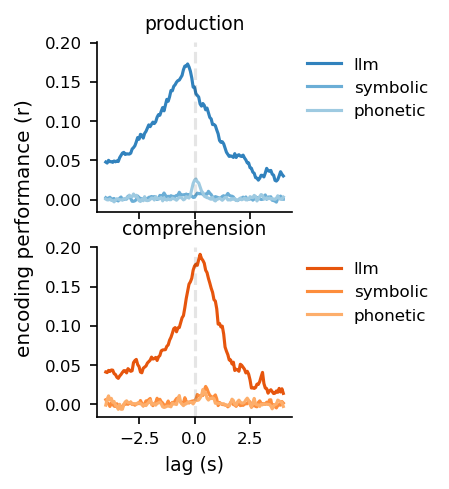

In [10]:
fig, axes = plt.subplots(
    2,
    1,
    figsize=(fs1c[1], fs1c[0] * 1.45),
    sharex=True,
    sharey=True,
)
ax = axes[0]
ax.set_title("production")
ax.plot(lags, prods[0], color=prod_colors[0], label="llm")
ax.plot(lags, prods[1], color=prod_colors[1], label="symbolic")
ax.plot(lags, prods[2], color=prod_colors[2], label="phonetic")
# ax.legend(ncol=3, bbox_to_anchor=(.75, 0), bbox_transform=fig.transFigure)
ax.legend(bbox_to_anchor=(1, 1))
formatenc(ax)

ax = axes[1]
ax.set_title("comprehension")
ax.plot(lags, comps[0], color=comp_colors[0], label="llm")
ax.plot(lags, comps[1], color=comp_colors[1], label="symbolic")
ax.plot(lags, comps[2], color=comp_colors[2], label="phonetic")
# ax.legend(ncol=3, bbox_to_anchor=(.75, -0.08), bbox_transform=fig.transFigure)
ax.legend(bbox_to_anchor=(1, 1))
formatenc(ax)

ax.set_xlabel("lag (s)")
fig.supylabel("encoding performance (r)", x=-0.2)

fig.savefig(f"{outdir}/fig-rev-bandedA.svg")
fig.show()

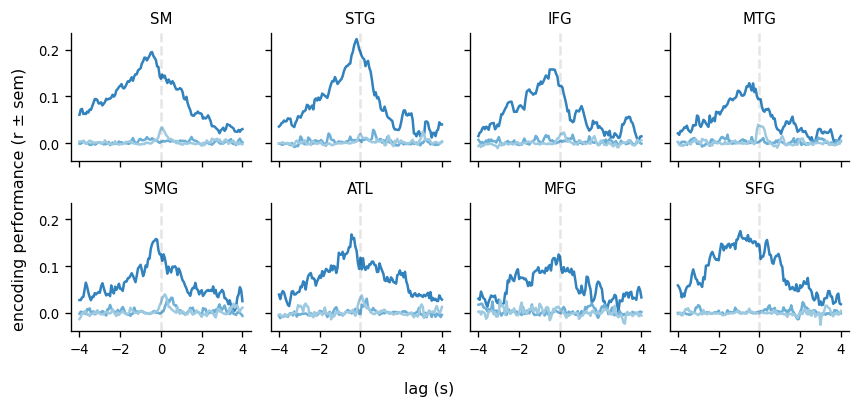

In [14]:
# Plot average per ROI
fig, axes = plt.subplots(
    2, 4, dpi=120, figsize=(7.24, 1.68 * 2), sharey=True, sharex=True
)

sig = None
sig = sigmasks
mode = "prod"

for roi, ax in zip(rois, axes.ravel()):
    values = []
    for sub in Ss:
        result = results[(sub, mode, modelname)]
        corrs = np.stack(result["corrs"])
        sigmask = sigmasks[(sub, mode)]
        roimask = np.in1d(result["rois"], ROIS[roi])
        elecmask = sigmask & roimask
        # print(sub, roi, sigmask.sum(), roimask.sum(), elecmask.sum())

        if elecmask.any():
            corrs = corrs[:, :, elecmask].mean((0, 2))
            values.append(corrs)

    values = np.stack(values).mean(0)  # avg over subjects

    ax.plot(lags, values[0], color=prod_colors[0], label="llm")
    ax.plot(lags, values[1], color=prod_colors[1], label="symbolic")
    ax.plot(lags, values[2], color=prod_colors[2], label="phonetic")

    formatenc(ax)
    # ax.text(0.05, 1, f'N={sum(NS)}', color=BLUE, transform=ax.transAxes, alpha=1, ha='left', va='top',  weight='bold', fontsize=6)
    # ax.text(0.05, .91, f'N={sum(NP)}', color=RED, transform=ax.transAxes, alpha=1, ha='left', va='top', weight='bold', fontsize=6)
    ax.set(title=roi)  # f'{roi} ({sum(NS)} {sum(NP)})')
    # ax.set_ylim(-.025, .32)
    ax.set_xticks(lags[:: lags.size // 4])

# axes[-1, -1].legend(loc='best', frameon=False)

fig.supylabel("encoding performance (r ± sem)")
fig.supxlabel("lag (s)")

fig.tight_layout()
fig.savefig(f"{outdir}/fig-rev-bandedB.svg")
plt.show()

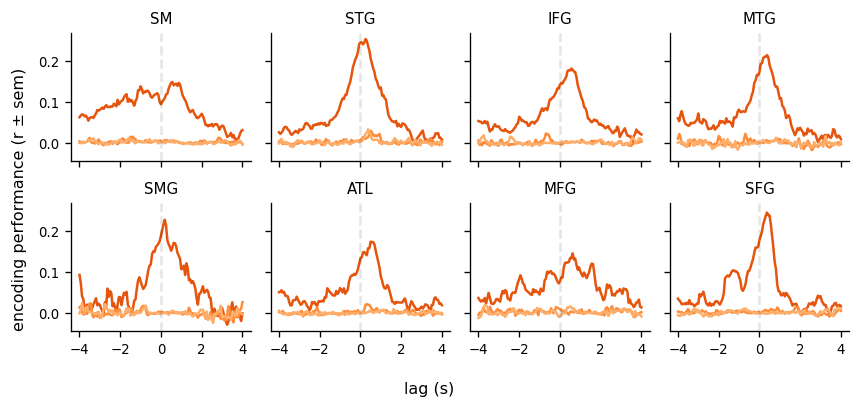

In [15]:
# Plot average per ROI
fig, axes = plt.subplots(
    2, 4, dpi=120, figsize=(7.24, 1.68 * 2), sharey=True, sharex=True
)

sig = None
sig = sigmasks
mode = "comp"

for roi, ax in zip(rois, axes.ravel()):
    values = []
    for sub in Ss:
        result = results[(sub, mode, modelname)]
        corrs = np.stack(result["corrs"])
        sigmask = sigmasks[(sub, mode)]
        roimask = np.in1d(result["rois"], ROIS[roi])
        elecmask = sigmask & roimask
        # print(sub, roi, sigmask.sum(), roimask.sum(), elecmask.sum())

        if elecmask.any():
            corrs = corrs[:, :, elecmask].mean((0, 2))
            values.append(corrs)

    values = np.stack(values).mean(0)  # avg over subjects

    ax.plot(lags, values[0], color=comp_colors[0], label="llm")
    ax.plot(lags, values[1], color=comp_colors[1], label="symbolic")
    ax.plot(lags, values[2], color=comp_colors[2], label="phonetic")

    formatenc(ax)
    # ax.text(0.05, 1, f'N={sum(NS)}', color=BLUE, transform=ax.transAxes, alpha=1, ha='left', va='top',  weight='bold', fontsize=6)
    # ax.text(0.05, .91, f'N={sum(NP)}', color=RED, transform=ax.transAxes, alpha=1, ha='left', va='top', weight='bold', fontsize=6)
    ax.set(title=roi)  # f'{roi} ({sum(NS)} {sum(NP)})')
    # ax.set_ylim(-.025, .32)
    ax.set_xticks(lags[:: lags.size // 4])

# axes[-1, -1].legend(loc='best', frameon=False)

fig.supylabel("encoding performance (r ± sem)")
fig.supxlabel("lag (s)")

fig.tight_layout()
fig.savefig(f"{outdir}/fig-rev-bandedC.svg")
plt.show()

In [ ]:
# coords = []
# for sub in Ss:
#     corrs = np.mean(results[(sub, mode, modelname)]['corrs'], axis=0).max(-1)
#     mask = sigmasks[(sub, mode)]
#     coords.append(allcoords[sub][mask].squeeze())
#     maxes.append(corrs[mask].squeeze())
# values = np.concatenate(maxes)
# coords = np.vstack(coords)
# order = np.argsort(values)
# plot_markers(values[order], coords[order], display_mode='l', figure=fig, axes=ax,
#                 node_vmax=vmax, node_vmin=vmin, node_size=15,
#                 colorbar=False, node_cmap='Reds' if i else 'Blues')

## weight compare in 2-folds

In [23]:
from scipy.spatial.distance import cdist

In [34]:
def weights_2f(subA, subB=None):
    subB = utils.getpartner(subA) if subB is None else subB

    coefsA = results[(subA, "prod", modelname)]["coefs"][0]
    coefsB = results[(subB, "comp", modelname)]["coefs"][1]

    sigA = sigmasks[(subA, "prod")]
    sigB = sigmasks[(subB, "comp")]

    coefsA = coefsA[:, sigA].mean(1)
    coefsB = coefsB[:, sigB].mean(1)

    C = 1 - cdist(coefsA.T, coefsB.T, metric="correlation")
    return C

In [44]:
M1 = np.stack([weights_2f(sub) for sub in Ss])
M1 = M1.mean(0)
M1.min(), M1.max()

(-0.06601082952949308, 0.10184895140460845)

In [39]:
i = 0
observed = []
null_distribution = np.empty((80, lags.size, lags.size))
for s in Ss:
    part = utils.getpartner(s)
    for p in Ss:
        if p != s and p != part:
            null_distribution[i] = weights_2f(s, p)
            i += 1
M2 = np.mean(null_distribution, 0)
M2.shape, M2.max()

((129, 129), 0.0671628404937355)

In [43]:
M3 = np.stack([weights_2f(sub, sub) for sub in Ss])
M3 = M3.mean(0)
M3.min(), M3.max()

(-0.06525797250436767, 0.08337577072832639)

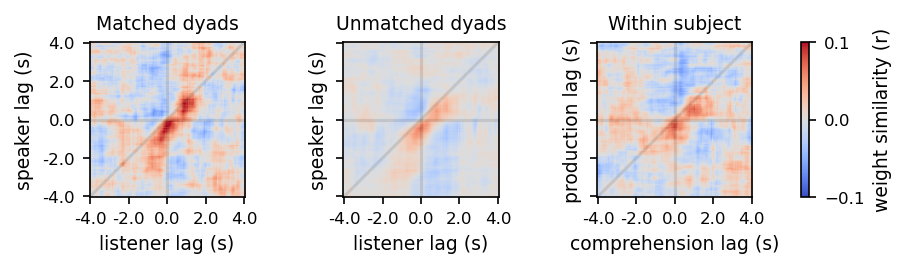

In [49]:
##
fig, axes = plt.subplots(
    1, 3, figsize=(6.2, 1.68), sharex=True, sharey=True, layout="constrained"
)

mx = 0.1

ax = axes[0]
im = ax.imshow(
    M1,
    origin="lower",
    interpolation=None,
    cmap="coolwarm",
    vmin=-mx,
    vmax=mx,
    aspect="equal",
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)", title="Matched dyads")

ax = axes[1]
im = ax.imshow(
    M2,
    origin="lower",
    interpolation=None,
    cmap="coolwarm",
    vmin=-mx,
    vmax=mx,
    aspect="equal",
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)", title="Unmatched dyads")

ax = axes[2]
im = ax.imshow(
    M3,
    origin="lower",
    interpolation=None,
    cmap="coolwarm",
    vmin=-mx,
    vmax=mx,
    aspect="equal",
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(
    xlabel="comprehension lag (s)", ylabel="production lag (s)", title="Within subject"
)

cbar = fig.colorbar(im, ax=axes)
# cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, orientation='vertical')#, shrink=0.85)
cbar.ax.set_ylabel("weight similarity (r)")
cbar.set_ticks([im.get_clim()[0], 0, im.get_clim()[-1]])

# fig.savefig(f'{outdir}/fig3s-weights.svg')
plt.show()

## electrode pairwise

In [78]:
M1, ns, ms = getMaps(
    results, Ss, modelname=modelname, significant=None, reduce=True, reduce_folds=True
)
M1.shape, M1.max(), M1.min()

((129, 129), 0.04782638571857014, -0.04682257678278972)

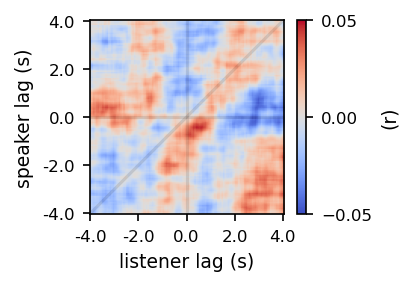

In [80]:
# Reproduce original result
mx = 0.05
fig, ax = plt.subplots(figsize=fs1c)
im = ax.imshow(
    M1, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx
)
formatim(fig, ax, im, lags, cbar_loc="v")
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")
fig.savefig(f"{outdir}/revision-ise-reproduce.svg")
fig.show()

In [119]:
# Compute pairwise correlations
M2, ns, ms = getMaps(
    results,
    Ss,
    modelname=modelname,
    significant=sigmasks,
    reduce=True,
    reduce_folds=True,
    reduction="pairwise",
)
M2.shape, M2.max(), M2.min()

((129, 129), 0.03364386311047065, -0.012538010735005989)

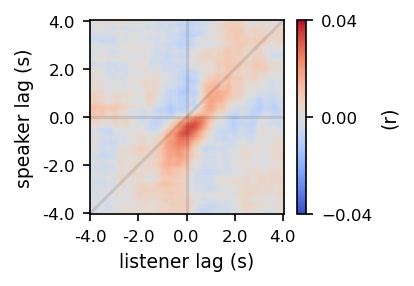

In [279]:
mx = 0.04
fig, ax = plt.subplots(figsize=fs1c)
im = ax.imshow(
    M2, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx
)
formatim(fig, ax, im, lags, cbar_loc="v")
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")
fig.savefig(f"{outdir}/revision-ise-pairwise.svg")
fig.show()

per region

In [120]:
# average 8x8 roixroi
M3, nS, nP = getMaps(
    results,
    Ss,
    modelname=modelname,
    reduce=True,
    weight=True,
    significant=sigmasks,
    rois=rois,
)
M4 = M3.mean((0, 1))
M3.shape, M3.max(), M3.min()

((8, 8, 129, 129), 0.21848369512528054, -0.2600087358262194)

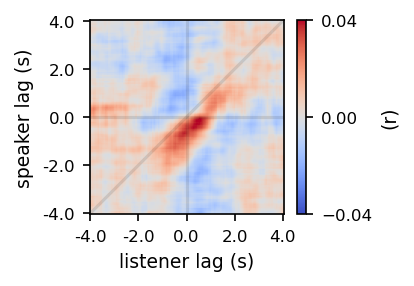

In [289]:
mx = 0.04
fig, ax = plt.subplots(figsize=fs1c)
im = ax.imshow(
    M4, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx
)
formatim(fig, ax, im, lags, cbar_loc="v")
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")
fig.savefig(f"{outdir}/revision-ise-roi-avg.svg")
fig.show()

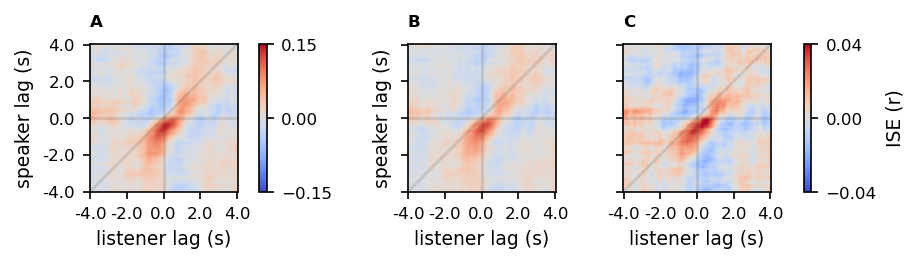

In [123]:
fig, axes = plt.subplots(
    1, 3, figsize=(6.2, 1.68), sharex=True, sharey=True, layout="constrained"
)

mx = 0.15

ax = axes[0]
im = ax.imshow(
    M1,
    origin="lower",
    interpolation=None,
    cmap="coolwarm",
    vmin=-mx,
    vmax=mx,
    aspect="equal",
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks([im.get_clim()[0], 0, im.get_clim()[-1]])

mx = 0.04

ax = axes[1]
im = ax.imshow(
    M2,
    origin="lower",
    interpolation=None,
    cmap="coolwarm",
    vmin=-mx,
    vmax=mx,
    aspect="equal",
)
formatim(fig, ax, im, lags, cbar_loc=None, yl=None)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")

ax = axes[2]
im = ax.imshow(
    M4,
    origin="lower",
    interpolation=None,
    cmap="coolwarm",
    vmin=-mx,
    vmax=mx,
    aspect="equal",
)
formatim(fig, ax, im, lags, cbar_loc=None, yl=None)
ax.set(xlabel="listener lag (s)")  # , ylabel='speaker lag (s)')

cbar = fig.colorbar(im, ax=axes[1:])
# cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, orientation='vertical')#, shrink=0.85)
cbar.ax.set_ylabel("ISE (r)")
cbar.set_ticks([im.get_clim()[0], 0, im.get_clim()[-1]])

axes[0].text(
    0,
    1.2,
    "A",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="top",
    transform=axes[0].transAxes,
)
axes[1].text(
    0,
    1.2,
    "B",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="top",
    transform=axes[1].transAxes,
)
axes[2].text(
    0,
    1.2,
    "C",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="top",
    transform=axes[2].transAxes,
)

# fig.savefig(f'{outdir}/fig3s-weights.svg')
plt.show()

## encoding context lengths

In [16]:
sizes = [2, 4, 8, 16, 32, 1024]  # 64, 1024
# models = ['model-glove-300_reg-l2']
models = ["model-gpt2-xl_maxlen-0_reg-l2"]
models += [f"model-gpt2-xl_maxlen-{d}_layer-24_reg-l2" for d in sizes]
models

['model-gpt2-xl_maxlen-0_reg-l2',
 'model-gpt2-xl_maxlen-2_layer-24_reg-l2',
 'model-gpt2-xl_maxlen-4_layer-24_reg-l2',
 'model-gpt2-xl_maxlen-8_layer-24_reg-l2',
 'model-gpt2-xl_maxlen-16_layer-24_reg-l2',
 'model-gpt2-xl_maxlen-32_layer-24_reg-l2',
 'model-gpt2-xl_maxlen-1024_layer-24_reg-l2']

In [7]:
# Load actual results
import gc

results = {}
for sub in Ss:
    for mode in modes:
        for mname in models:
            actual_pickle = glob.glob(
                f"{root}sub-{sub:02d}/{mname}/sub-{sub:02d}_task-conversation_encoding_mode-{mode}_band-{band}.pkl"
            )
            if not len(actual_pickle):
                actual_pickle = glob.glob(
                    f"{root}sub-{sub:02d}/{mname}/sub-{sub:02d}_task-conversation_encoding_mode-{mode}.pkl"
                )
            if not len(actual_pickle):
                actual_pickle = glob.glob(
                    f"{root}sub-{sub:02d}/{mname}/sub-{sub:02d}_task-conversation_encoding_mode-{mode}_band-{band}_nfolds-10.pkl"
                )
            if len(actual_pickle):
                print(sub, mode, mname)
                with open(actual_pickle[0], "rb") as f:
                    result = pickle.load(f)
                    results[(sub, mode, mname)] = result["corrs"]
                    del result
                    gc.collect()
# print(result.keys())
# results.keys()

1 prod model-gpt2-xl_maxlen-0_reg-l2
1 prod model-gpt2-xl_maxlen-2_layer-24_reg-l2
1 prod model-gpt2-xl_maxlen-4_layer-24_reg-l2
1 prod model-gpt2-xl_maxlen-8_layer-24_reg-l2
1 prod model-gpt2-xl_maxlen-16_layer-24_reg-l2
1 prod model-gpt2-xl_maxlen-32_layer-24_reg-l2
1 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
1 comp model-gpt2-xl_maxlen-0_reg-l2
1 comp model-gpt2-xl_maxlen-2_layer-24_reg-l2
1 comp model-gpt2-xl_maxlen-4_layer-24_reg-l2
1 comp model-gpt2-xl_maxlen-8_layer-24_reg-l2
1 comp model-gpt2-xl_maxlen-16_layer-24_reg-l2
1 comp model-gpt2-xl_maxlen-32_layer-24_reg-l2
1 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
2 prod model-gpt2-xl_maxlen-0_reg-l2
2 prod model-gpt2-xl_maxlen-2_layer-24_reg-l2
2 prod model-gpt2-xl_maxlen-4_layer-24_reg-l2
2 prod model-gpt2-xl_maxlen-8_layer-24_reg-l2
2 prod model-gpt2-xl_maxlen-16_layer-24_reg-l2
2 prod model-gpt2-xl_maxlen-32_layer-24_reg-l2
2 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
2 comp model-gpt2-xl_maxlen-0_reg-l2
2 comp mo

In [14]:
blues = sns.color_palette("Blues", n_colors=len(sizes) - 1)
reds = sns.color_palette("Reds", n_colors=len(sizes) - 1)

In [19]:
len(sizes), len(blues), len(models)

(6, 6, 7)

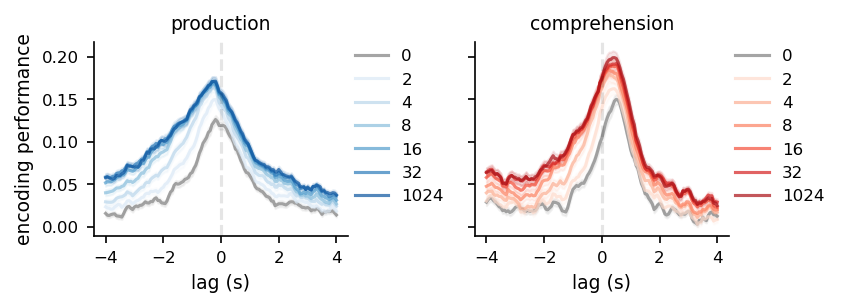

In [34]:
w = 7.24 / 2 - 0.5
fig, axes = plt.subplots(1, 2, figsize=(w * 1.75, 1.68), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.5)

ax = axes[0]
colors = ["gray"] + list(blues)
for d, mn, c in zip([0] + sizes, models, colors):
    elecs = np.vstack(
        [np.mean(results[(s, "prod", mn)], axis=0)[sigmasks[(s, "prod")]] for s in Ss]
    )
    mean, err = elecs.mean(0), elecs.std(0) / np.sqrt(elecs.shape[0])
    ax.plot(lags, mean, label=d, color=c, alpha=0.7)  # , zorder=2.1)
    ax.fill_between(lags, mean - err, mean + err, color=c, alpha=0.1)  # , zorder=2)

formatenc(ax)
ax.set_title("production")
ax.set(xlabel="lag (s)", ylabel="encoding performance")
# ax.legend(frameon=False, loc="upper right", borderaxespad=0.0)
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1), borderaxespad=0.0)

ax = axes[1]
colors = ["gray"] + list(reds)
for d, mn, c in zip([0] + sizes, models, colors):
    elecs = np.vstack(
        [np.mean(results[(s, "comp", mn)], axis=0)[sigmasks[(s, "comp")]] for s in Ss]
    )
    mean, err = elecs.mean(0), elecs.std(0) / np.sqrt(elecs.shape[0])
    ax.plot(lags, mean, label=d, color=c, alpha=0.7)  # , zorder=2.1)
    ax.fill_between(lags, mean - err, mean + err, color=c, alpha=0.1)  # , zorder=2)
formatenc(ax)
ax.set_title("comprehension")
ax.set(xlabel="lag (s)")
# ax.legend(frameon=False, loc="upper right", borderaxespad=0.0)
ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1), borderaxespad=0.0)

# fig.tight_layout()
# fig.savefig(f'{outdir}/fig3-ise-all2d.svg')
fig.show()

# Grant

## Get max encoding brain maps

In [7]:
outdir

'../results/paper/model-gpt2-xl_maxlen-0_reg-l2_perm-phase_method-fdr_bh_alpha-0.01/model-gpt2-xl_maxlen-1024_layer-24_reg-l2'

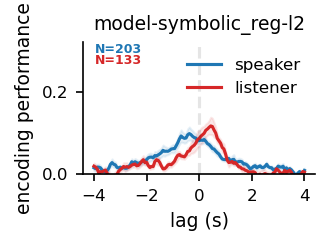

In [14]:
# Plot average per ROI
fig, ax = plt.subplots(sharey=True, sharex=True)

sig = sigmasks
MS, NS, _ = getMaps(
    results,
    Ss,
    modelname=modelname,
    speakerROI=ALL_ROIs,
    partnerROI=ALL_ROIs,
    mode="within-prod",
    significant=sig,
    reduce=False,
)
MP, _, NP = getMaps(
    results,
    Ss,
    modelname=modelname,
    speakerROI=ALL_ROIs,
    partnerROI=ALL_ROIs,
    mode="within-comp",
    significant=sig,
    reduce=False,
)

if n := np.count_nonzero(NS):
    mean = np.ma.mean(MS, axis=0)
    err = np.ma.std(MS, axis=0) / np.sqrt(n)
    ax.plot(lags, mean, label="speaker", color=BLUE)
    ax.fill_between(lags, mean - err, mean + err, color=BLUE, alpha=0.1)

if n := np.count_nonzero(NP):
    mean = np.ma.mean(MP, axis=0)
    err = np.ma.std(MP, axis=0) / np.sqrt(n)
    ax.plot(lags, mean, label="listener", color=RED)
    ax.fill_between(lags, mean - err, mean + err, color=RED, alpha=0.1)

formatenc(ax)
ax.text(
    0.05,
    1,
    f"N={sum(NS)}",
    color=BLUE,
    transform=ax.transAxes,
    alpha=1,
    ha="left",
    va="top",
    weight="bold",
    fontsize=6,
)
ax.text(
    0.05,
    0.91,
    f"N={sum(NP)}",
    color=RED,
    transform=ax.transAxes,
    alpha=1,
    ha="left",
    va="top",
    weight="bold",
    fontsize=6,
)
ax.set(title=modelname)  # f'{roi} ({sum(NS)} {sum(NP)})')
ax.set_ylim(0, 0.32)
ax.set_xticks(lags[:: lags.size // 4])

ax.legend(loc="best", frameon=False)

ax.set_ylabel("encoding performance")
ax.set_xlabel("lag (s)")

fig.tight_layout()
fig.savefig(f"{outdir}/fig-grant-encoding_lags-sig-{sig is not None}2.svg")
plt.show()

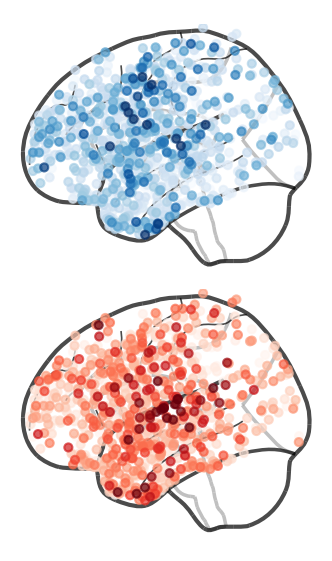

In [20]:
# plot_markers one axis is default to size [2.6, 2.3] in
vmin, vmax = 0.077759184, 0.4

sig = not True
fig, axes = plt.subplots(2, 1, figsize=(2.6 * 1, 2.3 * 2))
axes = axes.flatten()
fig.subplots_adjust(wspace=0, hspace=0)
for i, mode in enumerate(modes):
    ax = axes[i]
    maxes = []
    coords = []
    for sub in Ss:
        corrs = np.mean(results[(sub, mode, modelname)]["corrs"], axis=0).max(-1)
        mask = sigmasks[(sub, mode)] if sig else None
        coords.append(allcoords[sub][mask].squeeze())
        maxes.append(corrs[mask].squeeze())
    values = np.concatenate(maxes)
    coords = np.vstack(coords)
    order = np.argsort(values)
    plot_markers(
        values[order],
        coords[order],
        display_mode="l",
        figure=fig,
        axes=ax,
        node_vmax=vmax,
        node_vmin=vmin,
        node_size=15,
        colorbar=False,
        node_cmap="Reds" if i else "Blues",
    )

# bar_norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# fig.colorbar(mpl.cm.ScalarMappable(norm=bar_norm, cmap='Blues'), ax=axes)
# fig.colorbar(mpl.cm.ScalarMappable(norm=bar_norm, cmap='Reds'), label='encoding performance (r)', ax=axes)

# fig.suptitle(modelname)
# fig.savefig(f'{outdir}/fig-grant-encoding-brain-max_sig-{sig}2.svg')
plt.show()

## contrast

In [7]:
models

['model-whisper-tiny_reg-l2', 'model-gpt2-xl_maxlen-1024_layer-24_reg-l2']

model-whisper-tiny_reg-l2 prod
model-gpt2-xl_maxlen-1024_layer-24_reg-l2 prod
-0.3076082 0.24542797
model-whisper-tiny_reg-l2 comp
model-gpt2-xl_maxlen-1024_layer-24_reg-l2 comp
-0.33767152 0.24162346


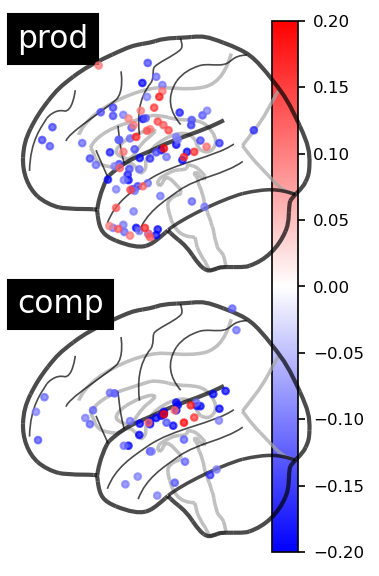

In [8]:
sig = True

# plot_markers one axis is default to size [2.6, 2.3] in
# vmin, vmax = 0.077759184, 0.4
vmin, vmax = -0.2, 0.2

fig, axes = plt.subplots(2, 1, figsize=(2.6 * 1, 2.3 * 2))
axes = axes.flatten()
fig.subplots_adjust(wspace=0, hspace=0)


for i, mode in enumerate(modes):
    vals = []
    for modelname in models:
        maxes = []
        coords = []
        print(modelname, mode)
        for sub in Ss:
            corrs = np.mean(results[(sub, mode, modelname)]["corrs"], axis=0).max(-1)
            mask = sigmasks[(sub, mode)] if sig else None
            coords.append(allcoords[sub][mask].squeeze())
            maxes.append(corrs[mask].squeeze())
        values = np.concatenate(maxes)
        coords = np.vstack(coords)
        vals.append(values)

    ax = axes[i]
    values = vals[0] - vals[1]
    mask2 = np.abs(values) > 0.1
    values = values[mask2]
    coords = coords[mask2]
    print(values.min(), values.max())
    order = np.argsort(values)
    plot_markers(
        values[order],
        coords[order],
        display_mode="l",
        figure=fig,
        axes=ax,
        node_vmax=vmax,
        node_vmin=vmin,
        title=mode,
        node_size=10,
        colorbar=False,
        node_cmap="bwr",
    )

bar_norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
fig.colorbar(mpl.cm.ScalarMappable(norm=bar_norm, cmap="bwr"), ax=axes)
# fig.colorbar(mpl.cm.ScalarMappable(norm=bar_norm, cmap='Reds'), label='encoding performance (r)', ax=axes)

# fig.suptitle(modelname)
fig.savefig(f"{outdir}/fig-grant-contrast-brain-max_sig-{sig}.svg")
plt.show()

## 2d plots

In [27]:
ROIS["SM"]

('PREC', 'PSTC')

In [9]:
# get actual result
M, nS, nP = getMaps(
    results,
    Ss,
    modelname=modelname,
    reduce=True,
    weight=True,
    significant=sigmasks,
    rois=rois,
)
M.shape, M.mask.any()

((8, 8, 129, 129), True)

In [6]:
# within speaker
M, nSs, nPs = getMaps(
    results,
    Ss,
    Ss,
    modelname=modelname,
    reduce=True,
    weight=True,
    rois=rois,
    significant=sigmasks,
    partMode="prod",
)
M.shape

(8, 8, 129, 129)

In [54]:
# within listener
M, nPs, nPl = getMaps(
    results,
    Ss,
    Ss,
    modelname=modelname,
    reduce=True,
    weight=True,
    rois=rois,
    significant=sigmasks,
    subMode="comp",
)
M.shape

(8, 8, 129, 129)

In [14]:
# # iner-subject
# s1, s2 = 'speaker', 'listener'
# roi1, roi2 = 'SM', 'STG'
# roi1, roi2 = 'SM', 'IFG'
# roi1, roi2 = 'STG', 'STG'
# roi1, roi2 = 'IFG', 'STG'
# roi1, roi2 = 'ATL', 'STG'

# intra-speaker
s1, s2 = "speaker", "speaker"
roi1, roi2 = "STG", "IFG"
roi1, roi2 = "SM", "IFG"
roi1, roi2 = "SM", "STG"

# # intra-listener
# s1, s2 = 'listener', 'listener'
# roi1, roi2 = 'STG', 'SMG'
# roi1, roi2 = 'STG', 'IFG'

333


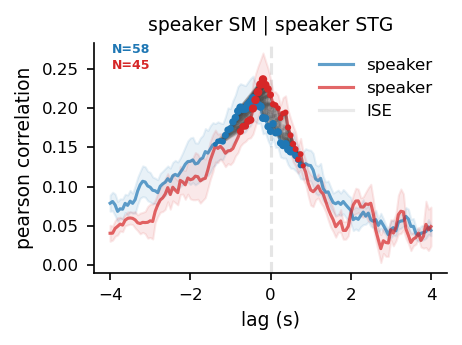

In [15]:
# Plot encoding with connections
mode1 = "within-prod" if s1 == "speaker" else "within-comp"
mode2 = "within-prod" if s2 == "speaker" else "within-comp"
MS, NS1, NP1 = getMaps(
    results,
    Ss,
    modelname=modelname,
    mode=mode1,
    speakerROI=ROIS[roi1],
    partnerROI=ROIS[roi1],
    significant=sigmasks,
    reduce=not True,
    weight=False,
)
MP, NS2, NP2 = getMaps(
    results,
    Ss,
    modelname=modelname,
    mode=mode2,
    speakerROI=ROIS[roi2],
    partnerROI=ROIS[roi2],
    significant=sigmasks,
    reduce=not True,
    weight=False,
)

NS = NS1 if s1 == "speaker" else NP1
NP = NS2 if s2 == "speaker" else NP2

# Plot within-subject lines for one ROI
(
    i,
    j,
) = rois.index(roi1), rois.index(roi2)
Z = M[i, j]

threshold_max = 0.052362467174286775  # from main model, may not be sufficient
w = 7.24 / 2 - 0.5
fig, ax = plt.subplots(figsize=(w, w / (4 / 3)))

if n := np.count_nonzero(NS):
    mean = np.ma.mean(MS, axis=0)
    err = np.ma.std(MS, axis=0) / np.sqrt(n)
    ax.plot(lags, mean, label=s1, color=BLUE, alpha=0.7, zorder=2.1)
    ax.fill_between(lags, mean - err, mean + err, color=BLUE, alpha=0.1, zorder=2)
    MS = mean

if n := np.count_nonzero(NP):
    mean = np.ma.mean(MP, axis=0)
    err = np.ma.std(MP, axis=0) / np.sqrt(n)
    ax.plot(lags, mean, label=s2, color=RED, alpha=0.7, zorder=2.1)
    ax.fill_between(lags, mean - err, mean + err, color=RED, alpha=0.1, zorder=2)
    MP = mean

z = Z > np.quantile(Z, 0.98)
# z = M > threshold_max
print(z.sum())

z0 = z.any(0).nonzero()[0]
z1 = z.any(1).nonzero()[0]

a = np.linalg.norm(Z, axis=0)[z0]
# a0 = np.interp(a, (a.min(), a.max()), (0.1, 1))
a0 = np.interp(a, (a.min(), a.max()), (2, 10))

a = np.linalg.norm(Z, axis=1)[z1]
# a1 = np.interp(a, (a.min(), a.max()), (0.1, 1))  # for alpha
a1 = np.interp(a, (a.min(), a.max()), (2, 10))  # for size

ax.scatter(lags[z1], MS[z1], alpha=1, zorder=2.9, s=a1, color=BLUE)
ax.scatter(lags[z0], MP[z0], alpha=1, zorder=2.9, s=a0, color=RED)

a = Z[np.nonzero(z)]
a2 = np.interp(a, (a.min(), a.max()), (0.1, 0.2))
a = a.argsort()
a3 = np.interp(a, (a.min(), a.max()), (2.1, 2.8))

# three color lines for before, cross, and after
a, b = np.nonzero(z)
for i, x, y in zip(range(len(a)), a, b):
    # lx, ly = lags[[x, y]]
    # if lx <= 0 and ly <= 0:
    #     c = 'orange'
    #     # ax.plot(lags[[x,y]], [MS[x], MP[y]], c=c, alpha=a2[i], zorder=a3[i])
    # elif lx <=0 and ly > 0:
    #     c = 'green'
    #     # ax.plot(lags[[x,y]], [MS[x], MP[y]], c=c, alpha=a2[i], zorder=a3[i])
    # else:
    #     c = 'purple'
    #     ax.plot(lags[[x,y]], [MS[x], MP[y]], c=c, alpha=a2[i], zorder=a3[i])
    line = ax.plot(
        lags[[x, y]],
        [MS[x], MP[y]],
        c=np.array([64, 64, 64]) / 255,
        alpha=a2[i],
        zorder=a3[i],
    )

line[0].set_label("ISE")

ax.text(
    0.05,
    1,
    f"N={sum(NS)}",
    color=BLUE,
    transform=ax.transAxes,
    alpha=1,
    ha="left",
    va="top",
    weight="bold",
    fontsize=6,
)
ax.text(
    0.05,
    0.93,
    f"N={sum(NP)}",
    color=RED,
    transform=ax.transAxes,
    alpha=1,
    ha="left",
    va="top",
    weight="bold",
    fontsize=6,
)

formatenc(ax)
ax.set(xlabel="lag (s)", ylabel="pearson correlation")  # , ylim=(-.01, .25))
ax.legend(frameon=False, loc="upper right")
ax.set_title(f"{s1} {roi1} | {s2} {roi2}")
# ax.set_ylim(0, ax.get_ylim()[1])
fig.tight_layout()
# fig.savefig(f'{outdir}/aim2-{s1}-{s2}-{roi1}-{roi2}.svg')
plt.show()

# Figure 1 - method

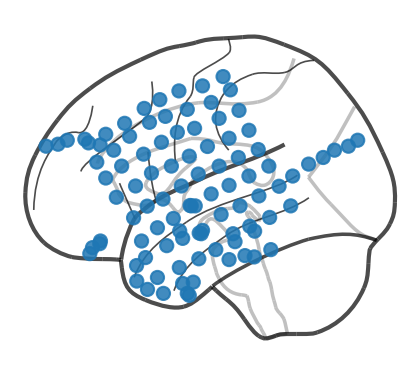

In [7]:
sub, label, num = 6, "blue", 0
# sub, label, num = 11, 'red', 3
coords = allcoords[sub]
# fig, ax = plt.subplots()

cmap = mpl.colors.ListedColormap(sns.color_palette().as_hex())
plot_markers(
    np.ones(len(coords)) * num,
    coords,
    display_mode="l",
    #  figure=fig, axes=ax,
    colorbar=False,
    node_cmap=cmap,
    alpha=0.85,
    node_vmin=0,
    node_vmax=9,
    node_size=40,
)
plt.savefig(f"{outdir}/fig1-brain-{label}.svg")
plt.show()

# Figure 2 - within subject encoding

-1 -0.07610107 0.3142794 226 226
-0.5 -0.056637645 0.40325513 226 226
0 -0.04154682 0.3447243 226 226
0.5 -0.11985673 0.36917937 226 226
1 -0.07935854 0.31441742 226 226
-1 -0.16812119 0.18244885 158 158
-0.5 -0.06002914 0.25048542 158 158
0 -0.09498875 0.4303947 158 158
0.5 -0.008024326 0.45614186 158 158
1 -0.023031577 0.2876758 158 158


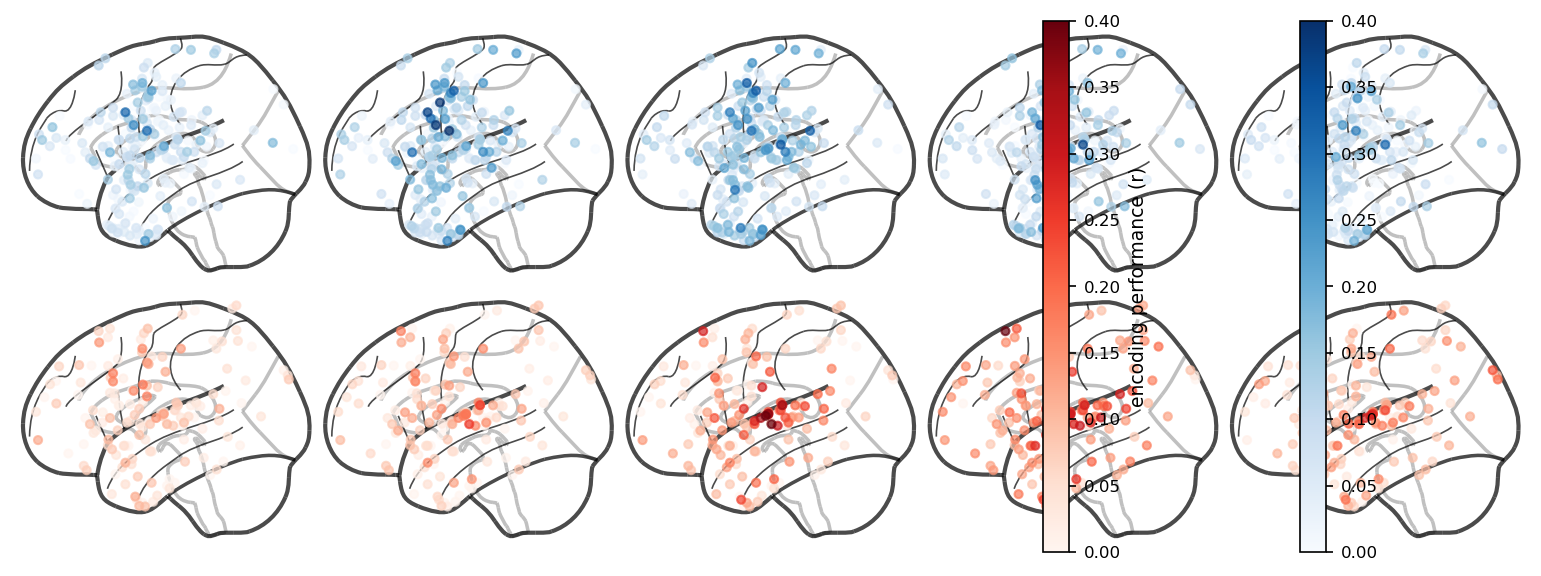

In [11]:
# plot_markers one axis is default to size [2.6, 2.3] in
vmin, vmax = 0, 0.3
vmin, vmax = 0, 0.4

sig = True
fig, axes = plt.subplots(2, 5, figsize=(2.6 * 5, 2.3 * 2))
fig.subplots_adjust(wspace=0, hspace=0)
for i, mode in enumerate(modes):
    # for j, sec in enumerate([-.5, -.25, 0, .25, .5]):
    for j, sec in enumerate([-1, -0.5, 0, 0.5, 1]):
        ax = axes[i, j]
        lag = (lags == sec).nonzero()[0].item()

        maxes = []
        coords = []
        for sub in Ss:
            corrs = np.mean(results[(sub, mode, modelname)]["corrs"], axis=0)[:, lag]
            mask = sigmasks[(sub, mode)] if sig else None
            coords.append(allcoords[sub][mask].squeeze())
            maxes.append(corrs[mask].squeeze())
        values = np.concatenate(maxes)
        coords = np.vstack(coords)
        order = np.argsort(values)
        print(sec, values.min(), values.max(), len(values), len(coords))
        plot_markers(
            values[order],
            coords[order],
            display_mode="l",
            figure=fig,
            axes=ax,
            node_vmax=vmax,
            node_vmin=vmin,
            node_size=15,
            colorbar=False,
            node_cmap="Reds" if i else "Blues",
        )

bar_norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
fig.colorbar(mpl.cm.ScalarMappable(norm=bar_norm, cmap="Blues"), ax=axes)
fig.colorbar(
    mpl.cm.ScalarMappable(norm=bar_norm, cmap="Reds"),
    label="encoding performance (r)",
    ax=axes,
)

# fig.suptitle(modelname)
fig.savefig(f"{outdir}/fig2-encoding-brain-lags_sig-{sig}.svg")
plt.show()

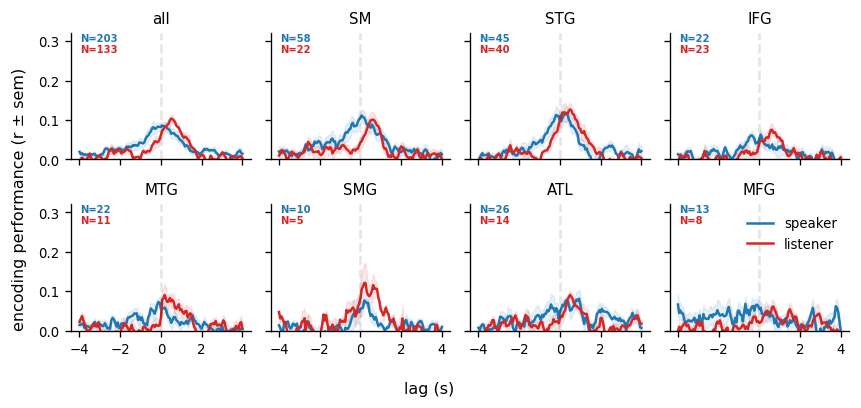

In [8]:
# Plot average per ROI
fig, axes = plt.subplots(
    2, 4, dpi=120, figsize=(7.24, 1.68 * 2), sharey=True, sharex=True
)

sig = None
sig = sigmasks

for roi, ax in zip(["all"] + rois[:-1], axes.flatten()):
    if roi != "all":
        MS, NS, _ = getMaps(
            results,
            Ss,
            modelname=modelname,
            speakerROI=ROIS[roi],
            partnerROI=ROIS[roi],
            mode="within-prod",
            significant=sig,
            reduce=False,
        )
        MP, _, NP = getMaps(
            results,
            Ss,
            modelname=modelname,
            speakerROI=ROIS[roi],
            partnerROI=ROIS[roi],
            mode="within-comp",
            significant=sig,
            reduce=False,
        )
    else:
        MS, NS, _ = getMaps(
            results,
            Ss,
            modelname=modelname,
            speakerROI=ALL_ROIs,
            partnerROI=ALL_ROIs,
            mode="within-prod",
            significant=sig,
            reduce=False,
        )
        MP, _, NP = getMaps(
            results,
            Ss,
            modelname=modelname,
            speakerROI=ALL_ROIs,
            partnerROI=ALL_ROIs,
            mode="within-comp",
            significant=sig,
            reduce=False,
        )

    if n := np.count_nonzero(NS):
        mean = np.ma.mean(MS, axis=0)
        err = np.ma.std(MS, axis=0) / np.sqrt(n)
        ax.plot(lags, mean, label="speaker", color=BLUE)
        ax.fill_between(lags, mean - err, mean + err, color=BLUE, alpha=0.1)

    if n := np.count_nonzero(NP):
        mean = np.ma.mean(MP, axis=0)
        err = np.ma.std(MP, axis=0) / np.sqrt(n)
        ax.plot(lags, mean, label="listener", color=RED)
        ax.fill_between(lags, mean - err, mean + err, color=RED, alpha=0.1)

    formatenc(ax)
    ax.text(
        0.05,
        1,
        f"N={sum(NS)}",
        color=BLUE,
        transform=ax.transAxes,
        alpha=1,
        ha="left",
        va="top",
        weight="bold",
        fontsize=6,
    )
    ax.text(
        0.05,
        0.91,
        f"N={sum(NP)}",
        color=RED,
        transform=ax.transAxes,
        alpha=1,
        ha="left",
        va="top",
        weight="bold",
        fontsize=6,
    )
    ax.set(title=roi)  # f'{roi} ({sum(NS)} {sum(NP)})')
    ax.set_ylim(0, 0.32)
    ax.set_xticks(lags[:: lags.size // 4])

axes[-1, -1].legend(loc="best", frameon=False)

fig.supylabel("encoding performance (r ± sem)")
fig.supxlabel("lag (s)")

fig.tight_layout()
fig.savefig(f"{outdir}/fig2-encoding-rois_sig-{sig is not None}.svg")
plt.show()

In [14]:
def lag_diff_statistic(x, y, axis):
    # x, y shapes are (perms, lags, elecs)
    # average over elecs, then calc absdiff in peak lags
    return np.abs(
        np.argmax(np.mean(x, axis=axis), axis=-1)
        - np.argmax(np.mean(y, axis=axis), axis=-1)
    )


def mag_diff_statistic(x, y, axis):
    # x, y shapes are (perms, lags, elecs)
    # average over elecs, then calc diff in peaks
    return np.max(np.mean(x, axis=axis), axis=-1) - np.max(
        np.mean(y, axis=axis), axis=-1
    )

In [45]:
n_perms = 10000
n_perms = 1

records = []
sig = sigmasks
for roi in ["all"] + rois:
    if roi != "all":
        MS, NS, _ = getMaps(
            results,
            Ss,
            modelname=modelname,
            speakerROI=ROIS[roi],
            partnerROI=ROIS[roi],
            mode="within-prod",
            significant=sig,
            reduce=False,
            reduce_elecs=False,
        )
        MP, _, NP = getMaps(
            results,
            Ss,
            modelname=modelname,
            speakerROI=ROIS[roi],
            partnerROI=ROIS[roi],
            mode="within-comp",
            significant=sig,
            reduce=False,
            reduce_elecs=False,
        )
    else:
        MS, NS, _ = getMaps(
            results,
            Ss,
            modelname=modelname,
            speakerROI=ALL_ROIs,
            partnerROI=ALL_ROIs,
            mode="within-prod",
            significant=sig,
            reduce=False,
            reduce_elecs=False,
        )
        MP, _, NP = getMaps(
            results,
            Ss,
            modelname=modelname,
            speakerROI=ALL_ROIs,
            partnerROI=ALL_ROIs,
            mode="within-comp",
            significant=sig,
            reduce=False,
            reduce_elecs=False,
        )

    # Exclude all masked entries
    MS = MS[~MS.mask.any(-1)].data
    MP = MP[~MP.mask.any(-1)].data

    meanS = MS.mean(0)
    meanP = MP.mean(0)
    bestLagS = meanS.argmax()
    bestLagP = meanP.argmax()

    lag_permres = permutation_test(
        (MS, MP),
        statistic=lag_diff_statistic,
        vectorized=True,
        axis=0,
        permutation_type="independent",
        n_resamples=n_perms,
        alternative="greater",
    )
    mag_permres = permutation_test(
        (MS, MP),
        statistic=mag_diff_statistic,
        vectorized=True,
        axis=0,
        permutation_type="independent",
        n_resamples=n_perms,
    )

    records.append(
        {
            "roi": roi,
            "lag_prod": lags[bestLagS],
            "lag_comp": lags[bestLagP],
            "lag_diff": lag_permres.statistic * jump,
            "lag_pvalue_corr": lag_permres.pvalue,
            "mag_prod": meanS[bestLagS],
            "mag_comp": meanP[bestLagP],
            "mag_diff": mag_permres.statistic,
            "mag_pvalue_corr": mag_permres.pvalue,
        }
    )

df = pd.DataFrame(records)
df["lag_pvalue_corr"] = multipletests(df.lag_pvalue_corr.values, method="fdr_bh")[1]
df["mag_pvalue_corr"] = multipletests(df.mag_pvalue_corr.values, method="fdr_bh")[1]
# df['lag_pvalue_corr'] = [df.lag_pvalue_corr[0].item()] + multipletests(df.lag_pvalue_corr.values[1:], method='fdr_bh')[1].tolist()
# df['mag_pvalue_corr'] = [df.mag_pvalue_corr[0].item()] + multipletests(df.mag_pvalue_corr.values[1:], method='fdr_bh')[1].tolist()
df

roi  lag_prod  lag_comp  lag_diff  lag_pvalue_corr  mag_prod  mag_comp  \
0  all    0.0625    0.3125    0.2500             0.75  0.077184  0.068402   
1   SM    0.0625   -1.3750    1.4375             0.75  0.092020  0.052420   
2  STG    0.1875    0.3125    0.1250             0.75  0.074122  0.128649   
3  IFG    0.1875    0.5625    0.3750             0.75  0.058701  0.047432   
4  MTG    0.0625    0.2500    0.1875             1.00  0.093413  0.057934   
5  SMG    0.1875   -0.7500    0.9375             0.75  0.101434  0.060686   
6  ATL    0.0625    0.5000    0.4375             0.75  0.095331  0.062996   
7  MFG   -0.1875    0.6875    0.8750             1.00  0.053975  0.050027   
8  SFG   -0.5000    0.5000    1.0000             1.00  0.063665  0.062920   

   mag_diff  mag_pvalue_corr  
0  0.008782              1.0  
1  0.039600              1.0  
2 -0.054527              1.0  
3  0.011269              1.0  
4  0.035480              1.0  
5  0.040749              1.0  
6  0.032335              1.0  
7  0.003948              1.0  
8  0.000745              1.0

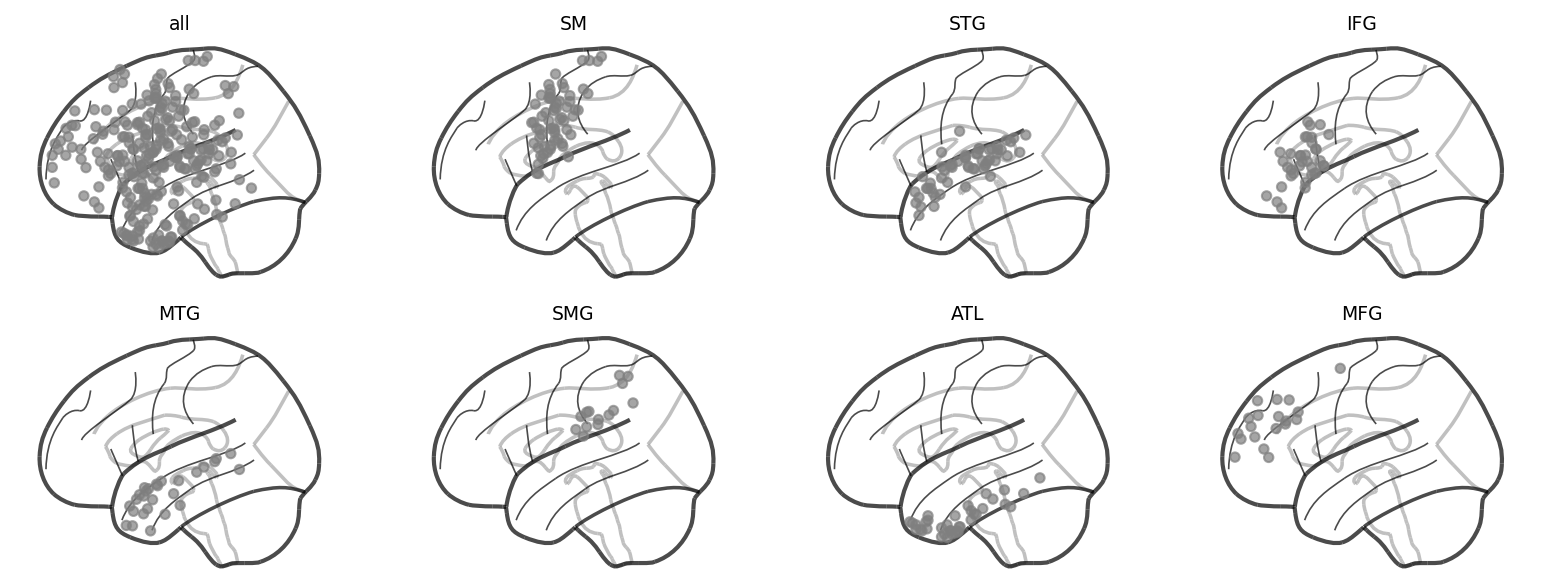

In [10]:
# Plot each ROI separately both prod + comp for shcematics mostly
# plot_markers one axis is default to size [2.6, 2.3] in
# fig, axes = plt.subplots(2, 4, dpi=120, figsize=(14, 4))
fig, axes = plt.subplots(2, 4, figsize=(2.6 * 5, 2.3 * 2))
for roi, ax in zip(["all"] + list(ROIS.keys()), axes.flatten()):
    maxes = []
    coords = []
    for sub in Ss:
        rois = ROIS[roi] if roi != "all" else sum(list(ROIS.values()), ())
        roimask = np.in1d(results[(sub, "prod", modelname)]["rois"], rois)
        mask = sigmasks[(sub, "prod")] & roimask
        mask |= sigmasks[(sub, "comp")] & roimask
        # corrs = np.mean(results[(sub, mode, modelname)]['corrs'], 0)
        coords.append(allcoords[sub][mask])
        # maxes.append(corrs.max(-1)[mask])

    # values = np.concatenate(maxes)
    coords = np.vstack(coords)
    values = np.ones(len(coords)) * 7
    if len(values) == 1:
        values = np.repeat(values, 2)
        coords = np.repeat(coords, 2, axis=0)

    order = np.argsort(values)
    # print(values.min(), values.max(), len(values))

    plot_markers(
        values[order],
        coords[order],
        display_mode="l",
        figure=fig,
        axes=ax,
        node_vmax=9,
        node_vmin=0,
        node_size=20,
        colorbar=False,
        node_cmap=mpl.colors.ListedColormap(sns.color_palette().as_hex()),
    )
    ax.set_title(roi)

fig.savefig(f"{outdir}/fig2-brain-roi-sig-schematics.svg")
plt.show()

# Figure 3 - intersubject encoding

In [9]:
# save for sig test later
M, ns, ms = getMaps(
    results,
    Ss,
    modelname=modelname,
    significant=sigmasks,
    reduce=False,
    reduce_folds=False,
)
np.savez(f"{outdir}/data-fig3-ise.npz", observed=M)

In [12]:
# Load permutated null distribution
# this can be generated from sigtest.py
path = derivpath(f"sub-all_model-{modelname}_perm-phase.npz", derivative="ise")
file = np.load(path.fpath)
observed = file["observed"]
null_distribution = file["null_distribution"]
null_distribution.shape, observed.shape

((1000, 129, 129), (129, 129))

In [13]:
# Calculate pvalue for max
obsmax = observed.max(keepdims=True)
null_maxes = null_distribution.max((1, 2), keepdims=True)[..., 0]
# pvalues = calculate_pvalues(observed.max(), null_maxes, alternative='greater')
pvalues = cdf_pvalues(obsmax, null_maxes, alternative="greater").item()
threshold_max = norm.ppf(0.99, loc=null_maxes.mean(), scale=null_maxes.std())
immask = observed <= threshold_max
pvalues, threshold_max

(6.698108468507153e-36, 0.052362467174286775)

0.14427377168280145
Max is at [-0.4375  0.125 ]


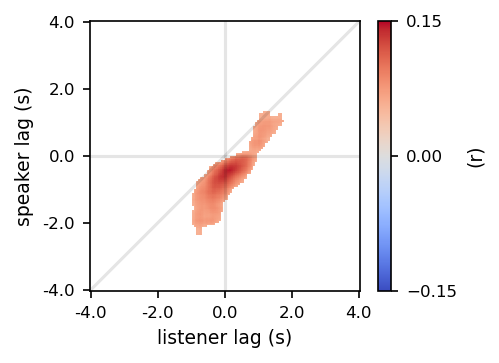

In [14]:
# Plot thresholdedimage

threshold_max = 0.052362467174286775  # from main model

M = np.ma.array(observed)
immask = observed <= threshold_max  # for plotting we'll be more strict
M.mask = immask
print(M.max())
mx = 0.15

w = 7.24 / 2 - 0.5
fig, ax = plt.subplots(figsize=(w, w / (4 / 3)))
im = ax.imshow(
    M, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx
)
formatim(fig, ax, im, lags, cbar_loc="v")
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")

# utils.plot_outlines((M > threshold).T, ax=ax, color='white', alpha=0.7, zorder=3)

print("Max is at", lags[np.array(np.unravel_index(M.argmax(), M.shape))])
fig.savefig(f"{outdir}/fig3s-ise-all-threshold.svg")
plt.show()

0.07033179377068545
Max is at [-0.0625  0.5   ]


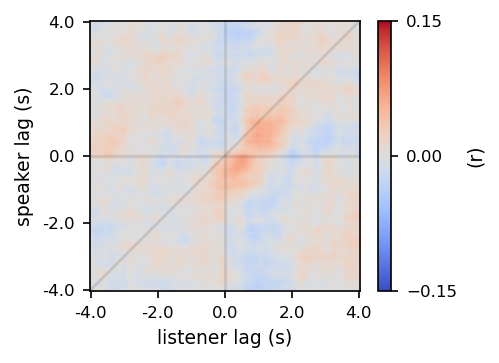

In [10]:
# Plot main ISE result
M, ns, ms = getMaps(
    results, Ss, modelname=modelname, significant=sigmasks, reduce=True, weight=True
)
mx = M.max()
print(mx)
mx = 0.05
mx = 0.15

w = 7.24 / 2 - 0.5
fig, ax = plt.subplots(figsize=(w, w / (4 / 3)))  # half 3c
im = ax.imshow(
    M, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx
)
formatim(fig, ax, im, lags, cbar_loc="v")
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")
print("Max is at", lags[np.array(np.unravel_index(M.argmax(), M.shape))])

fig.savefig(f"{outdir}/fig3-ise-all.svg")
plt.show()

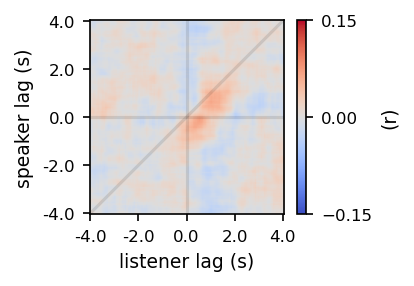

In [11]:
# Plot smaller version of it
mx = 0.15

fig, ax = plt.subplots(figsize=fs1c)
im = ax.imshow(
    M, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx
)
formatim(fig, ax, im, lags)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")

fig.savefig(f"{outdir}/fig3-ise-all-small.svg")
plt.show()

404


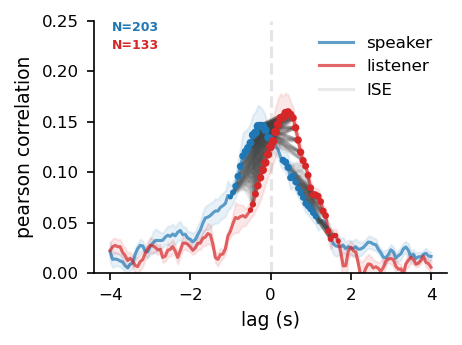

In [18]:
MS, NS, _ = getMaps(
    results,
    Ss,
    modelname=modelname,
    mode="within-prod",
    speakerROI=ALL_ROIs,
    partnerROI=ALL_ROIs,
    significant=sigmasks,
    reduce=not True,
    weight=False,
)
MP, _, NP = getMaps(
    results,
    Ss,
    modelname=modelname,
    mode="within-comp",
    speakerROI=ALL_ROIs,
    partnerROI=ALL_ROIs,
    significant=sigmasks,
    reduce=not True,
    weight=False,
)

# print(MS.max(), MP.max())
# Plot within-subject lines for one ROI
# i, j, = rois.index(speakerROI), rois.index(partnerROI)
# Z = M[i, j]
Z = M

fig, ax = plt.subplots(figsize=(w, w / (4 / 3)))

if n := np.count_nonzero(NS):
    mean = np.ma.mean(MS, axis=0)
    err = np.ma.std(MS, axis=0) / np.sqrt(n)
    ax.plot(lags, mean, label="speaker", color=BLUE, alpha=0.7, zorder=2.1)
    ax.fill_between(lags, mean - err, mean + err, color=BLUE, alpha=0.1, zorder=2)
    MS = mean

if n := np.count_nonzero(NP):
    mean = np.ma.mean(MP, axis=0)
    err = np.ma.std(MP, axis=0) / np.sqrt(n)
    ax.plot(lags, mean, label="listener", color=RED, alpha=0.7, zorder=2.1)
    ax.fill_between(lags, mean - err, mean + err, color=RED, alpha=0.1, zorder=2)
    MP = mean

# z = Z > np.quantile(Z, .98)
# threshold_max = 0.052362467174286775  # from main model
z = M > threshold_max
print(z.sum())

z0 = z.any(0).nonzero()[0]
z1 = z.any(1).nonzero()[0]

a = np.linalg.norm(Z, axis=0)[z0]
# a0 = np.interp(a, (a.min(), a.max()), (0.1, 1))
a0 = np.interp(a, (a.min(), a.max()), (2, 10))

a = np.linalg.norm(Z, axis=1)[z1]
# a1 = np.interp(a, (a.min(), a.max()), (0.1, 1))  # for alpha
a1 = np.interp(a, (a.min(), a.max()), (2, 10))  # for size

ax.scatter(lags[z1], MS[z1], alpha=1, zorder=2.9, s=a1, color=BLUE)
ax.scatter(lags[z0], MP[z0], alpha=1, zorder=2.9, s=a0, color=RED)

a = Z[np.nonzero(z)]
a2 = np.interp(a, (a.min(), a.max()), (0.1, 0.2))
a = a.argsort()
a3 = np.interp(a, (a.min(), a.max()), (2.1, 2.8))

# three color lines for before, cross, and after
a, b = np.nonzero(z)
for i, x, y in zip(range(len(a)), a, b):
    # lx, ly = lags[[x, y]]
    # if lx <= 0 and ly <= 0:
    #     c = 'orange'
    #     # ax.plot(lags[[x,y]], [MS[x], MP[y]], c=c, alpha=a2[i], zorder=a3[i])
    # elif lx <=0 and ly > 0:
    #     c = 'green'
    #     # ax.plot(lags[[x,y]], [MS[x], MP[y]], c=c, alpha=a2[i], zorder=a3[i])
    # else:
    #     c = 'purple'
    #     ax.plot(lags[[x,y]], [MS[x], MP[y]], c=c, alpha=a2[i], zorder=a3[i])
    line = ax.plot(
        lags[[x, y]],
        [MS[x], MP[y]],
        c=np.array([64, 64, 64]) / 255,
        alpha=a2[i],
        zorder=a3[i],
    )

line[0].set_label("ISE")

ax.text(
    0.05,
    1,
    f"N={sum(NS)}",
    color=BLUE,
    transform=ax.transAxes,
    alpha=1,
    ha="left",
    va="top",
    weight="bold",
    fontsize=6,
)
ax.text(
    0.05,
    0.93,
    f"N={sum(NP)}",
    color=RED,
    transform=ax.transAxes,
    alpha=1,
    ha="left",
    va="top",
    weight="bold",
    fontsize=6,
)

formatenc(ax)
ax.set(xlabel="lag (s)", ylabel="pearson correlation", ylim=(-0.01, 0.25))
ax.legend(frameon=False, loc="upper right")
# ax.set_title(f'ISE ({sum(NS)} {sum(NP)})')
ax.set_ylim(0, ax.get_ylim()[1])
fig.tight_layout()
fig.savefig(f"{outdir}/fig3-ise-all2d.svg")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (129,) and (1,)

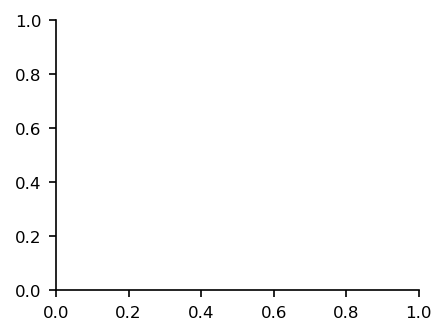

In [19]:
fig, ax = plt.subplots(figsize=(w, w / (4 / 3)))

if n := np.count_nonzero(NS):
    mean = np.ma.mean(MS, axis=0)
    err = np.ma.std(MS, axis=0) / np.sqrt(n)
    ax.plot(lags, mean, label="speaker", color=BLUE, alpha=0.7, zorder=2.1)
    ax.fill_between(lags, mean - err, mean + err, color=BLUE, alpha=0.1, zorder=2)
    MS = mean

if n := np.count_nonzero(NP):
    mean = np.ma.mean(MP, axis=0)
    err = np.ma.std(MP, axis=0) / np.sqrt(n)
    ax.plot(lags, mean, label="listener", color=RED, alpha=0.7, zorder=2.1)
    ax.fill_between(lags, mean - err, mean + err, color=RED, alpha=0.1, zorder=2)
    MP = mean

ax.text(
    0.05,
    1,
    f"N={sum(NS)}",
    color=BLUE,
    transform=ax.transAxes,
    alpha=1,
    ha="left",
    va="top",
    weight="bold",
    fontsize=6,
)
ax.text(
    0.05,
    0.93,
    f"N={sum(NP)}",
    color=RED,
    transform=ax.transAxes,
    alpha=1,
    ha="left",
    va="top",
    weight="bold",
    fontsize=6,
)

formatenc(ax)
ax.set(xlabel="lag (s)", ylabel="pearson correlation", ylim=(-0.01, 0.25))
ax.legend(frameon=False, loc="upper right")
# ax.set_title(f'ISE ({sum(NS)} {sum(NP)})')
ax.set_ylim(0, ax.get_ylim()[1])
fig.tight_layout()
fig.savefig(f"{outdir}/fig2-enc-all.svg")
plt.show()

0.1291882671231563


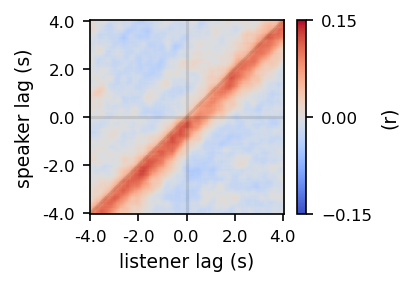

In [18]:
M, ns, ms = getMaps(
    results,
    Ss,
    modelname=modelname,
    mode="direct",
    significant=sigmasks,
    reduce=True,
    weight=True,
)

mx = M.max()
print(mx)
mx = 0.05
mx = 0.15

fig, ax = plt.subplots(figsize=fs1c)
im = ax.imshow(
    M,
    origin="lower",
    interpolation=None,
    cmap="coolwarm",
    vmin=-mx,
    vmax=mx,
    aspect="equal",
)
formatim(fig, ax, im, lags, cbar_loc="v", cbar_sym=False)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")

# fig.tight_layout()
fig.savefig(f"{outdir}/fig3-isfc-all.svg")
plt.show()

0.07542534 0.44864416 226
0.07865417 0.58002394 158


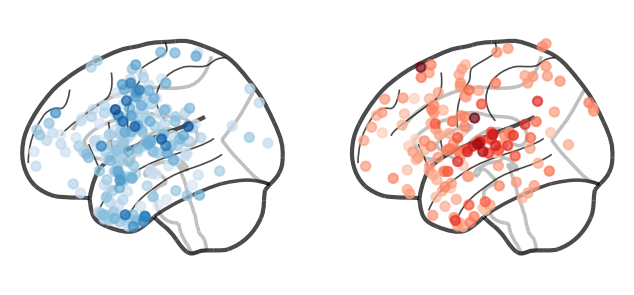

In [16]:
# Plot one brain for speaker, listener max per electrode
maxcorrs = {}
maxcoords = {}
for mode in modes:
    maxes = []
    coords = []
    trfs = []
    for sub in Ss:
        mask = sigmasks[(sub, mode)]
        corrs = np.mean(results[(sub, mode, modelname)]["corrs"], axis=0)
        coords.append(allcoords[sub][mask])
        maxes.append(corrs.max(-1)[mask])
        trfs.append(corrs[mask])
    maxcorrs[mode] = np.concatenate(maxes)
    maxcoords[mode] = np.vstack(coords)

fig, axes = plt.subplots(1, 2, figsize=(2.6 * 2, 2.3))
for i, mode, ax in zip(range(len(axes)), modes, axes):
    values = maxcorrs[mode]
    coords = maxcoords[mode]
    order = np.argsort(values)
    print(values.min(), values.max(), len(values))
    plot_markers(
        values[order],
        coords[order],
        display_mode="l",
        figure=fig,
        axes=ax,
        node_vmax=0.5,
        node_vmin=vmin,
        node_size=20,
        colorbar=not True,
        node_cmap="Reds" if i else "Blues",
    )
    # ax.set_title(mode)
# fig.suptitle(modelname)
fig.savefig(f"{outdir}/fig3-encoding-brain-max-prodcomp.svg")
plt.show()

## Figure S3.1 - matched/unmatched weights

In [10]:
i = 0
observed = []
null_distribution = np.empty((80, lags.size, lags.size))
for s in Ss:
    part = utils.getpartner(s)
    for p in Ss:
        if p != s and p != part:
            null_distribution[i], _, _ = getMaps(
                results,
                [s],
                [p],
                modelname=modelname,
                mode="weights",
                significant=sigmasks,
                reduce=False,
            )
            i += 1
        elif p == part:
            observed.append(
                getMaps(
                    results,
                    [s],
                    [p],
                    modelname=modelname,
                    mode="weights",
                    significant=sigmasks,
                    reduce=False,
                )[0]
            )
observed = np.vstack(observed)
M2 = np.mean(null_distribution, 0)
M2.shape, M2.max()

((129, 129), 0.12667357617613376)

In [11]:
M2.max()

0.12667357617613376

In [12]:
M1, _, _ = getMaps(
    results,
    Ss,
    modelname=modelname,
    mode="weights",
    significant=sigmasks,
    reduce=True,
    weight=False,
)
M1.shape, M1.max()

((129, 129), 0.26036859570523824)

0.26036859570523824 0.12667357617613376


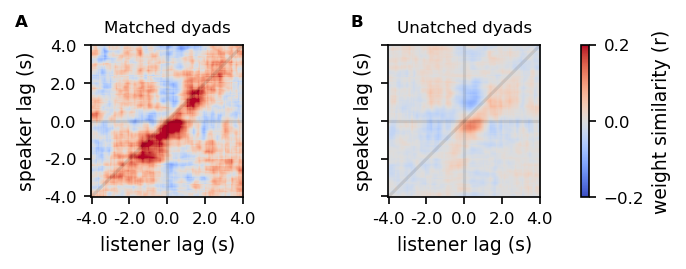

In [23]:
##
fig, axes = plt.subplots(
    1, 2, figsize=(fs2c[0], 1.68), sharex=True, sharey=True, layout="constrained"
)

print(M1.max(), M2.max())

mx = 0.2

ax = axes[0]
im = ax.imshow(
    M1,
    origin="lower",
    interpolation=None,
    cmap="coolwarm",
    vmin=-mx,
    vmax=mx,
    aspect="equal",
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")
ax.set_title("Matched dyads", fontsize=8)

ax = axes[1]
im = ax.imshow(
    M2,
    origin="lower",
    interpolation=None,
    cmap="coolwarm",
    vmin=-mx,
    vmax=mx,
    aspect="equal",
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)")
ax.set_title("Unatched dyads", fontsize=8)

cbar = fig.colorbar(im, ax=axes)
# cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, orientation='vertical')#, shrink=0.85)
cbar.ax.set_ylabel("weight similarity (r)")
cbar.set_ticks([im.get_clim()[0], 0, im.get_clim()[-1]])

axes[0].text(
    -0.50,
    1.2,
    "A",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="top",
    transform=axes[0].transAxes,
)
axes[1].text(
    -0.25,
    1.2,
    "B",
    fontweight="bold",
    horizontalalignment="left",
    verticalalignment="top",
    transform=axes[1].transAxes,
)

fig.show()

In [28]:
M3, _, _ = getMaps(
    results,
    Ss,
    Ps=Ss,
    modelname=modelname,
    mode="weights",
    significant=sigmasks,
    reduce=True,
    weight=False,
)
M3.shape, M3.max()

((129, 129), 0.10103267163092804)

0.2579381271251719 0.07620227350632341


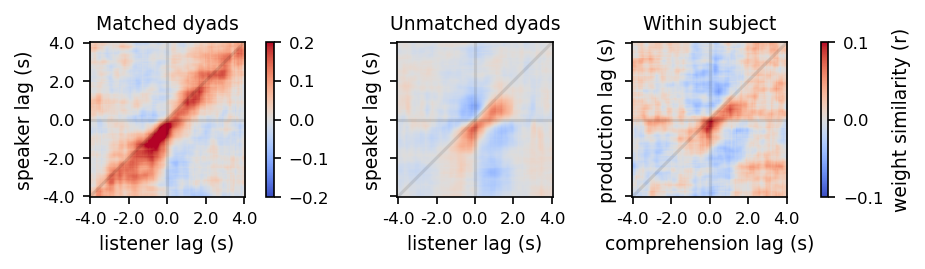

In [39]:
##
w = 7.24  # / 3 - .5
fig, axes = plt.subplots(
    1, 3, figsize=(6.2, 1.68), sharex=True, sharey=True, layout="constrained"
)

print(M1.max(), M2.max())

mx = 0.2

ax = axes[0]
im = ax.imshow(
    M1,
    origin="lower",
    interpolation=None,
    cmap="coolwarm",
    vmin=-mx,
    vmax=mx,
    aspect="equal",
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)", title="Matched dyads")
cbar = fig.colorbar(im, ax=ax)

mx = 0.1

ax = axes[1]
im = ax.imshow(
    M2,
    origin="lower",
    interpolation=None,
    cmap="coolwarm",
    vmin=-mx,
    vmax=mx,
    aspect="equal",
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(xlabel="listener lag (s)", ylabel="speaker lag (s)", title="Unmatched dyads")

ax = axes[2]
im = ax.imshow(
    M3,
    origin="lower",
    interpolation=None,
    cmap="coolwarm",
    vmin=-mx,
    vmax=mx,
    aspect="equal",
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(
    xlabel="comprehension lag (s)", ylabel="production lag (s)", title="Within subject"
)

cbar = fig.colorbar(im, ax=axes[1:])
# cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, orientation='vertical')#, shrink=0.85)
cbar.ax.set_ylabel("weight similarity (r)")
cbar.set_ticks([im.get_clim()[0], 0, im.get_clim()[-1]])

# fig.savefig(f'{outdir}/fig3s-weights.svg')
plt.show()

In [45]:
null_corr_dist = get_null_dist(size=1600)
calculate_pvalues(np.array([M1.max(), M2.max(), M3.max()]), null_corr_dist[:, None])

array([0.00019998, 0.00319968, 0.00019998])

# Figure 4 - inter-regional ISE

In [6]:
rois = list(ROIS.keys())

In [9]:
# get actual result
M, nS, nP = getMaps(
    results,
    Ss,
    modelname=modelname,
    reduce=True,
    weight=True,
    significant=sigmasks,
    rois=rois,
)
M.shape, M.mask.any()

((8, 8, 129, 129), True)

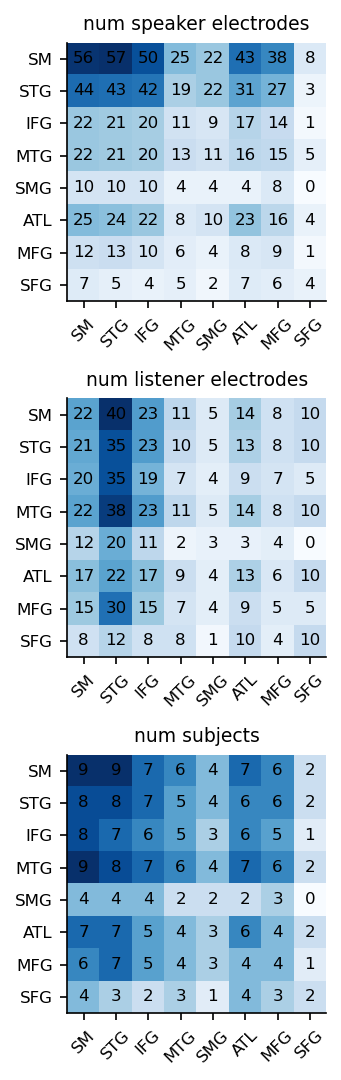

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(fs2c[0], fs3c[0]))

Z = nS.sum(0)
im = axes[0].imshow(Z, cmap="Blues", vmin=0)
axes[0].set_title("num speaker electrodes")
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        axes[0].text(j, i, str(Z[i, j]), va="center", ha="center")

Z = nP.sum(0)
im = axes[1].imshow(Z, cmap="Blues", vmin=0)
axes[1].set_title("num listener electrodes")
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        axes[1].text(j, i, str(Z[i, j]), va="center", ha="center")

Z = (nP > 0).sum(0)
im = axes[2].imshow(Z, cmap="Blues", vmin=0)
axes[2].set_title("num subjects")
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        axes[2].text(j, i, str(Z[i, j]), va="center", ha="center")

x = np.arange(len(rois))
for ax in axes:
    ax.set(xticks=x, yticks=x, yticklabels=rois)
    ax.set_xticklabels(rois, rotation=45)

# fig.supylabel('speaker ROIs')
# fig.supxlabel('listener ROIs')

fig.tight_layout()
fig.savefig(f"{outdir}/fig4s_mode-spklst_roicounts.svg")
plt.show()

In [137]:
subsiglimit = 4
submask = np.empty_like(M.mask)
limit = (nS > 0).sum(0) < subsiglimit
for i in range(8):
    for j in range(8):
        submask[i, j] = limit[i, j]
M.mask = submask

In [129]:
# Load null distribution
path = derivpath(
    f"sub-all_mode-spklst_model-{modelname}_perm-phase.npz", derivative="ise"
)
file = np.load(path.fpath)
null_distribution = file["null_distribution"]
null_distribution.shape

(1000, 8, 8, 129, 129)

In [130]:
# Calc pval per lag
pvalues = cdf_pvalues(M[None, ...], null_distribution).squeeze()
np.nanmin(pvalues)

/scratch/gpfs/zzada/conda-envs/b2b/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2251: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


1.869610442145555e-33

In [138]:
# correct across lags and rois
method, alpha = "bonf", 0.05

if method == "bonf":
    # manually bonf to account for masked values
    n_tests = float(M.mask.size - M.mask.sum())
    alphacBonf = alpha / n_tests
    pvalues_ma = np.ma.array(pvalues, mask=M.mask)
    sigs = (pvalues_ma <= alphacBonf).filled(False)
else:
    sigs, _, _, _ = multipletests(pvalues.flatten(), method=method, alpha=alpha)
    sigs = sigs.reshape(M.shape)
    sigs = np.ma.array(sigs.reshape(M.shape), mask=M.mask)
    sigs = sigs.filled(False)

sigs.sum(), sigs.any((2, 3)).sum()

(8721, 29)

In [139]:
# Ensure there at least `cc_limit` connected sig lags
cc_limit = 20
cc_n = np.zeros((8, 8), dtype=int)
sigs_label = np.zeros_like(sigs)
for i in range(8):
    for j in range(8):
        if sigs[i, j].any():
            labelmap = measure.label(sigs[i, j], connectivity=2)
            labels, counts = np.unique(labelmap, return_counts=True)

            sortedcounts = labels[counts[1:].argsort() + 1]
            sigs_label[i, j] = labelmap == sortedcounts[-1]
            if len(sortedcounts) > 1:
                sigs_label[i, j] |= labelmap == sortedcounts[-2]

            maxcount = counts[
                1:
            ].max()  # skip label `0` corresponding to non-sig lag pairs
            cc_n[i, j] = maxcount
            if maxcount < cc_limit:
                sigs[i, j] = False
cc_n

array([[   0, 1687,  730,   88,    0,  606,    0,    0],
       [ 360,  397,   10,    5,    1,  155,    5,    0],
       [ 111,   87,    0,   54,    0,  263,    8,    0],
       [ 271,  163,   93,    3,    0,   54,    3,    0],
       [   0,  172,    1,    0,    0,    0,    0,    0],
       [   0,  316,    2,    0,    0,  174,    0,    0],
       [ 989,    0,    0,    0,    0,    0,    8,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0]])

In [140]:
sigs.sum((2, 3))

array([[   0, 1762,  814,  114,    0,  608,    0,    0],
       [ 810,  397,    0,    0,    0,  155,    0,    0],
       [ 157,  138,    0,   54,    0,  342,    0,    0],
       [ 297,  250,  140,    0,    0,   58,    0,    0],
       [   0,  287,    0,    0,    0,    0,    0,    0],
       [   0,  490,    0,    0,    0,  177,    0,    0],
       [1613,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0]])

In [141]:
# M.mask = M.mask | (~sigs)
M.mask = ~sigs
M.max()

0.21848369512528054

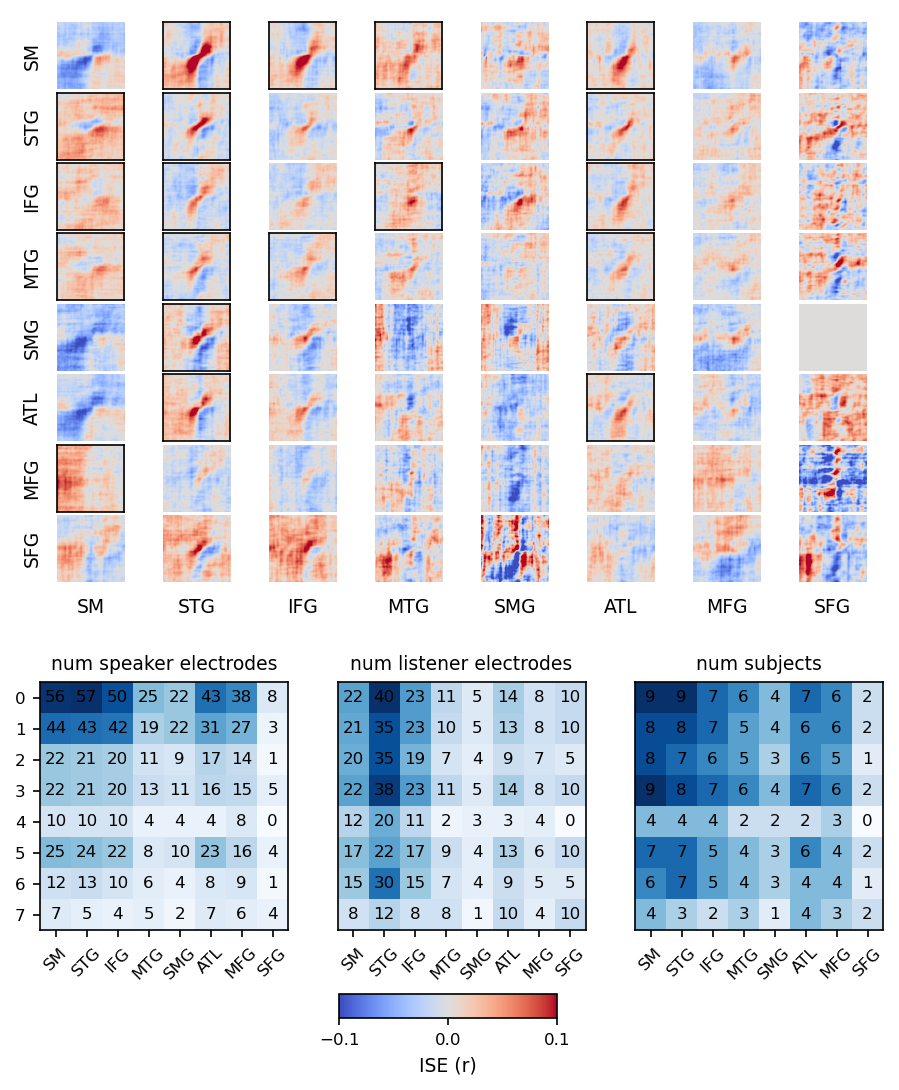

In [17]:
mx = 0.1

fig = plt.figure(figsize=(7.25, 8))
gs0 = mpl.gridspec.GridSpec(2, 1, figure=fig, height_ratios=[2, 1], wspace=0.1)

# Left side
nrow, ncol = 8, 8
gs00 = gs0[0].subgridspec(8, 8, wspace=0.05, hspace=0.05)
for i in range(nrow):
    for j in range(ncol):
        ax = fig.add_subplot(gs00[i, j])
        if sigs[i, j].any():
            im = ax.matshow(
                M[i, j].data,
                origin="lower",
                interpolation=None,
                cmap="coolwarm",
                vmin=-mx,
                vmax=mx,
            )
            ax.spines.right.set_visible(True)
            ax.spines.top.set_visible(True)
        else:
            im = ax.matshow(
                M[i, j].data,
                origin="lower",
                interpolation=None,
                cmap="coolwarm",
                vmin=-mx,
                vmax=mx,
            )
            ax.spines.left.set_visible(False)
            ax.spines.bottom.set_visible(False)
        ax.set(xticks=[], yticks=[])
        if j == 0:
            ax.set_ylabel(rois[i])
        if i == nrow - 1:
            ax.set_xlabel(rois[j])

# Right side
gs01 = gs0[1].subgridspec(1, 3)
x = np.arange(len(rois))

ax = fig.add_subplot(gs01[0, 0])
Z = nS.sum(0)
ax.imshow(Z, cmap="Blues", vmin=0)
ax.set_title("num speaker electrodes")
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        ax.text(j, i, str(Z[i, j]), va="center", ha="center")
ax.set(xticks=x, yticks=x)
ax.set_xticklabels(rois, rotation=45)
ax.spines.right.set_visible(True)
ax.spines.top.set_visible(True)

ax = fig.add_subplot(gs01[0, 1])
Z = nP.sum(0)
ax.imshow(Z, cmap="Blues", vmin=0)
ax.set_title("num listener electrodes")
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        ax.text(j, i, str(Z[i, j]), va="center", ha="center")
ax.set(xticks=x, yticks=())
ax.set_xticklabels(rois, rotation=45)
ax.spines.right.set_visible(True)
ax.spines.top.set_visible(True)

ax = fig.add_subplot(gs01[0, 2])
Z = (nP > 0).sum(0)
ax.imshow(Z, cmap="Blues", vmin=0)
ax.set_title("num subjects")
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        ax.text(j, i, str(Z[i, j]), va="center", ha="center")
ax.set(xticks=x, yticks=())
ax.set_xticklabels(rois, rotation=45)
ax.spines.right.set_visible(True)
ax.spines.top.set_visible(True)

# colorbar
cax = plt.axes([0.4, 0.05, 0.2, 0.02])  # left, bottom, width, height
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_ticks([-mx, 0, mx])
cbar.set_label("ISE (r)")

plt.show()

/tmp/ipykernel_1539915/1893908426.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[i, j])


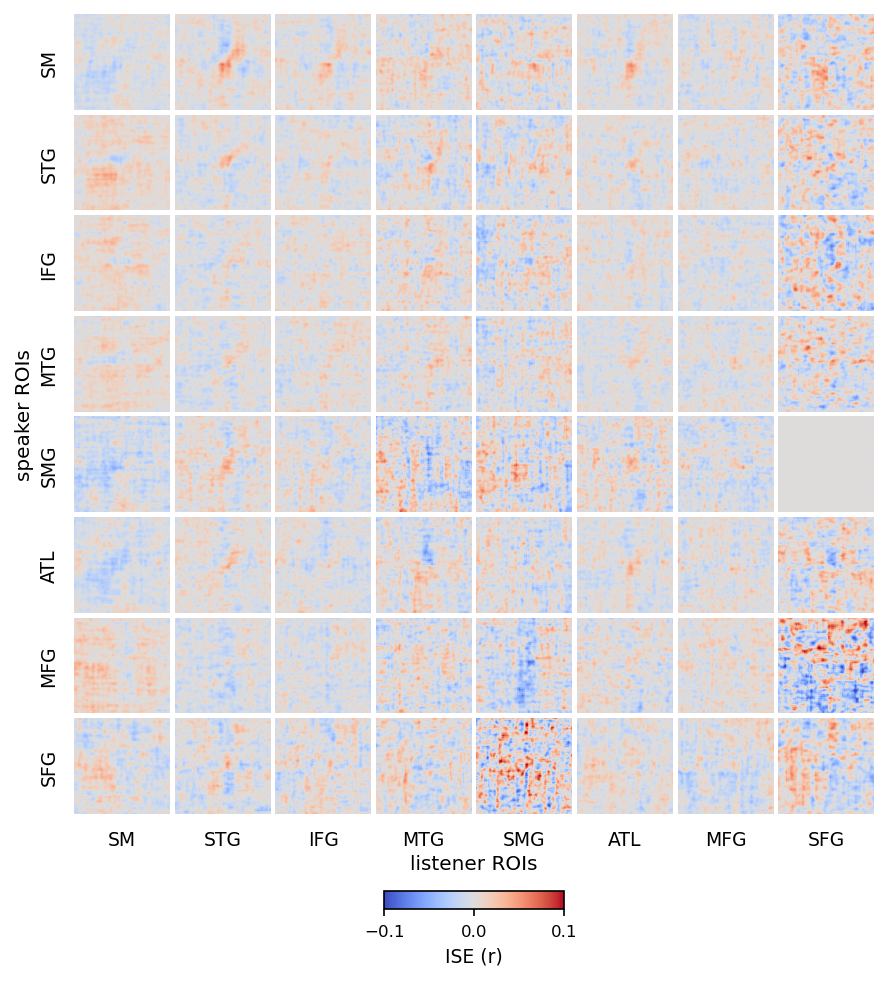

In [13]:
# Plot all parcels
mx = 0.1
onlysig = False

fig, axes = plt.subplots(len(rois), len(rois), figsize=(6, 6))
nrow, ncol = 8, 8
gs = mpl.gridspec.GridSpec(
    nrow,
    ncol,
    wspace=0.05,
    hspace=0.05,
    top=1.0 - 0.5 / (nrow + 1),
    bottom=0.5 / (nrow + 1),
    left=0.5 / (ncol + 1),
    right=1 - 0.5 / (ncol + 1),
)

for i, roi1 in enumerate(rois):
    for j, roi2 in enumerate(rois):
        ax = plt.subplot(gs[i, j])
        # im = ax.matshow(~M[i, j].mask, origin='lower', interpolation=None, cmap='Greys', vmin=0, vmax=1, aspect='equal')
        # if not onlysig and sigs[i,j].any():
        #     im = ax.matshow(M[i, j].data, origin='lower', interpolation=None, cmap='coolwarm', vmin=-mx, vmax=mx)
        #     ax.spines.right.set_visible(True)
        #     ax.spines.top.set_visible(True)
        # else:
        if True:
            im = ax.matshow(
                M[i, j].data,
                origin="lower",
                interpolation=None,
                cmap="coolwarm",
                vmin=-mx,
                vmax=mx,
            )
            ax.spines.left.set_visible(False)
            ax.spines.bottom.set_visible(False)
        ax.set(xticks=[], yticks=[])
        if j == 0:
            ax.set_ylabel(rois[i])
        if i == nrow - 1:
            ax.set_xlabel(rois[j])

# cbar = fig.colorbar(im, ax=gs, shrink=0.5, orientation='horizontal')
cax = plt.axes([0.4, -0.05, 0.2, 0.02])  # left, bottom, width, height
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_ticks([-mx, 0, mx])
cbar.set_label("ISE (r)")

fig.supylabel("speaker ROIs", x=-0.01)
fig.supxlabel("listener ROIs", y=-0.01)

fig.savefig(f"{outdir}/fig4s_ise-full_mode-spklst_onlysig-{onlysig}_roixroi.svg")
plt.show()

0.06946589617918424 0.21848369512528054


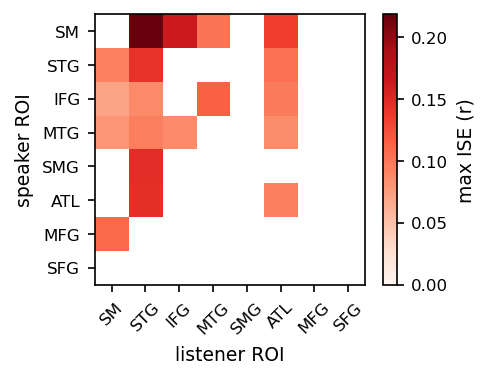

In [ ]:
# Plot roi x roi
w = 7.24 / 2 - 0.5
fig, ax = plt.subplots(figsize=(w, w * (3 / 4)))

Mmax = M.max((2, 3))
# Mmax.mask = ~sigs.any((2,3))
print(Mmax.min(), Mmax.max())
im = ax.imshow(Mmax, cmap="Reds", vmin=0)

# x, y = np.nonzero(sigs.any((2,3)))
# ax.scatter(y, x, marker='*', color='yellow', s=8)

ax.set(xlabel="listener ROI", ylabel="speaker ROI")
ax.set_xticks(range(len(rois)))
ax.set_yticks(range(len(rois)))
ax.set_xticklabels(rois, rotation=45)
ax.set_yticklabels(rois)
ax.spines.right.set_visible(True)
ax.spines.top.set_visible(True)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("max ISE (r)")
# cbar.set_ticks([0, mx])

fig.savefig(f"{outdir}/fig4_mode-spklst_roisummary.svg")
plt.show()

## within-speaker

In [142]:
Ms, nSs, nPs = getMaps(
    results,
    Ss,
    Ss,
    modelname=modelname,
    reduce=True,
    weight=True,
    rois=rois,
    significant=sigmasks,
    partMode="prod",
)
Ms.shape

(8, 8, 129, 129)

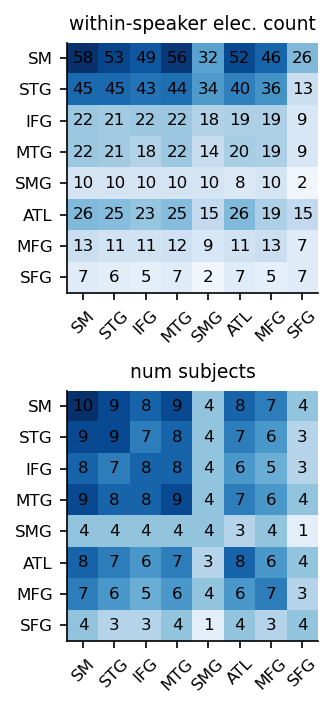

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(fs2c[0], fs2c[0]))

Z = nSs.sum(0)
im = axes[0].imshow(Z, cmap="Blues", vmin=0)
axes[0].set_title("within-speaker elec. count")
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        axes[0].text(j, i, str(Z[i, j]), va="center", ha="center")

Z = (nPs > 0).sum(0)
im = axes[1].imshow(Z, cmap="Blues", vmin=0)
axes[1].set_title("num subjects")
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        axes[1].text(j, i, str(Z[i, j]), va="center", ha="center")

x = np.arange(len(rois))
for ax in axes:
    ax.set(xticks=x, yticks=x, yticklabels=rois)
    ax.set_xticklabels(rois, rotation=45)

# fig.supylabel('speaker ROIs')
# fig.supxlabel('listener ROIs')

fig.tight_layout()
fig.savefig(f"{outdir}/fig4s_mode-spk_roicounts.svg")
plt.show()

In [143]:
submask = np.empty_like(Ms.mask)
limit = (nSs > 0).sum(0) < subsiglimit
for i in range(8):
    for j in range(8):
        submask[i, j] = limit[i, j]
Ms.mask = submask

In [144]:
# Load null distribution
path = derivpath(
    f"sub-all_mode-speaker_model-{modelname}_perm-phase.npz", derivative="ise"
)
file = np.load(path.fpath)
null_distribution = file["null_distribution"]
null_distribution.shape

(1012, 8, 8, 129, 129)

In [145]:
# Calc pval per lag
pvalues = cdf_pvalues(Ms[None, ...], null_distribution).squeeze()

if method == "bonf":
    n_tests = float(Ms.mask.size - Ms.mask.sum())
    alphacBonf = alpha / n_tests
    pvalues = np.ma.array(pvalues, mask=Ms.mask)
    sigsS = (pvalues <= alphacBonf).filled(False)
else:
    sigsS, _, _, _ = multipletests(pvalues.flatten(), method=method, alpha=alpha)
    sigsS = np.ma.array(sigsS.reshape(Ms.shape), mask=Ms.mask)
    sigsS = sigsS.filled(False)

# Ensure there at least `cc_limit` connected sig lags
sigsS_label = np.zeros_like(sigsS)
for i in range(8):
    for j in range(8):
        if sigsS[i, j].any():
            labelmap = measure.label(sigsS[i, j], connectivity=2)
            labels, counts = np.unique(labelmap, return_counts=True)

            sortedcounts = labels[counts[1:].argsort() + 1]
            sigsS_label[i, j] = labelmap == sortedcounts[-1]
            if len(sortedcounts) > 1:
                sigsS_label[i, j] |= labelmap == sortedcounts[-2]

            if counts[1:].max() < cc_limit:
                print(rois[i], rois[j], counts[1:].max())
                sigsS[i, j] = False

sigsS = sigsS.reshape(Ms.shape)
sigsS.sum(), sigsS.any((2, 3)).sum()

SM MFG 17
SM SFG 2
MTG SFG 1
ATL SFG 14
MFG SM 17
SFG SM 2
SFG MTG 1
SFG ATL 14


(47458, 34)

In [146]:
Ms.mask = ~sigsS
Ms.max(), np.triu(Ms.max((2, 3)).filled(0), 1).max()

(0.28010698848295906, 0.1875180403510249)

0.09111194644144958 0.28010698848295906


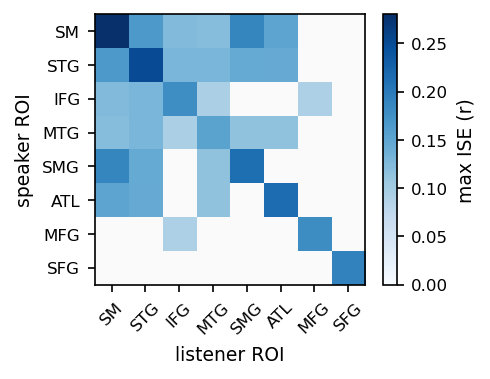

In [ ]:
# Plot roi x roi
w = 7.24 / 2 - 0.5
fig, ax = plt.subplots(figsize=(w, w * (3 / 4)))

palette = plt.cm.Blues.with_extremes(bad="#fafafa")

Mmax = Ms.max((2, 3))
# Mmax.mask[np.triu_indices_from(Mmax, 1)] = True
print(Mmax.min(), Mmax.max())
im = ax.imshow(Mmax, cmap=palette, vmin=0)  # , vmax=mx)

# x, y = np.nonzero(sigs.any((2,3)))
# ax.scatter(y, x, marker='*', color='yellow', s=8)

ax.set(xlabel="listener ROI", ylabel="speaker ROI")
ax.set_xticks(range(len(rois)))
ax.set_yticks(range(len(rois)))
ax.set_xticklabels(rois, rotation=45)
ax.set_yticklabels(rois)
ax.spines.right.set_visible(True)
ax.spines.top.set_visible(True)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("max ISE (r)")
# cbar.set_ticks([0, mx])

fig.savefig(f"{outdir}/fig4_mode-spk_roisummary.svg")
plt.show()

/tmp/ipykernel_1251012/3005881564.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[i, j])


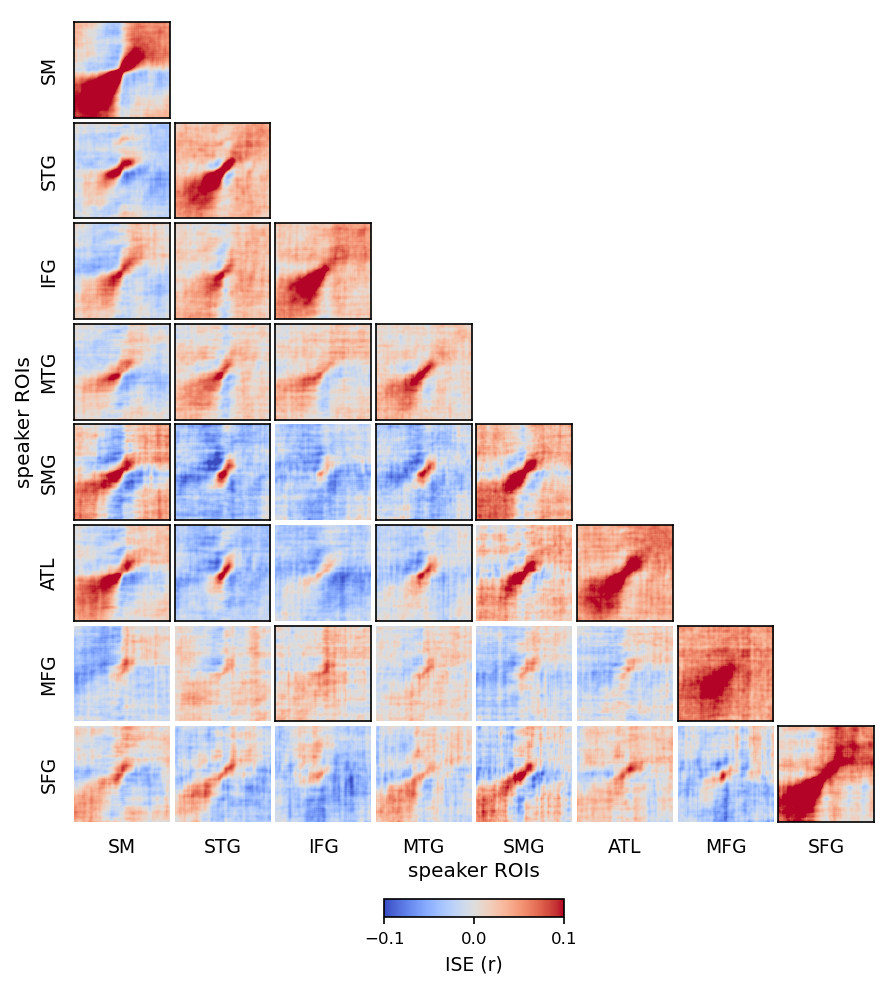

In [ ]:
# Plot all parcels within speaker
mx = 0.10

nrow, ncol = 8, 8
fig, axes = plt.subplots(nrow, ncol, figsize=(6, 6))
gs = mpl.gridspec.GridSpec(
    nrow,
    ncol,
    wspace=0.05,
    hspace=0.05,
    top=1.0 - 0.5 / (nrow + 1),
    bottom=0.5 / (nrow + 1),
    left=0.5 / (ncol + 1),
    right=1 - 0.5 / (ncol + 1),
)

for i, roi1 in enumerate(rois):
    for j in range(i + 1, len(rois)):
        ax = axes[i, j]
        ax.spines.left.set_visible(False)
        ax.spines.bottom.set_visible(False)
        ax.set(xticks=[], yticks=[])

    for j in range(i + 1):
        # for j in range(8):
        rois2 = rois[j]
        ax = plt.subplot(gs[i, j])
        im = ax.matshow(
            Ms[i, j].data,
            origin="lower",
            interpolation=None,
            cmap="coolwarm",
            vmin=-mx,
            vmax=mx,
        )
        # im = ax.matshow(~Ms[i, j].mask, origin='lower', interpolation=None, cmap='Greys', vmin=0, vmax=1)
        ax.set(xticks=[], yticks=[])
        if sigsS[i, j].any():
            ax.spines.right.set_visible(True)
            ax.spines.top.set_visible(True)
        else:
            ax.spines.left.set_visible(False)
            ax.spines.bottom.set_visible(False)
        if j == 0:
            ax.set_ylabel(rois[i])
        if i == nrow - 1:
            ax.set_xlabel(rois[j])

# cbar = fig.colorbar(im, ax=axes, shrink=0.5)
cax = plt.axes([0.4, -0.05, 0.2, 0.02])  # left, bottom, width, height
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_ticks([-mx, 0, mx])
cbar.set_label("ISE (r)")

fig.supylabel("speaker ROIs", x=-0.01)
fig.supxlabel("speaker ROIs", y=-0.01)

fig.savefig(f"{outdir}/fig4s_ise-full_mode-spk_roixroi.svg")
plt.show()

## within-listener

In [147]:
Ml, nPs, nPl = getMaps(
    results,
    Ss,
    Ss,
    modelname=modelname,
    reduce=True,
    weight=True,
    rois=rois,
    significant=sigmasks,
    subMode="comp",
)
Ml.shape

(8, 8, 129, 129)

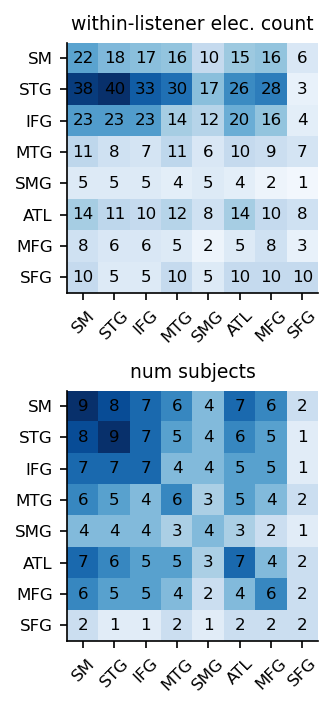

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(fs2c[0], fs2c[0]))

Z = nPs.sum(0)
im = axes[0].imshow(Z, cmap="Blues", vmin=0)
axes[0].set_title("within-listener elec. count")
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        axes[0].text(j, i, str(Z[i, j]), va="center", ha="center")

Z = (nPs > 0).sum(0)
im = axes[1].imshow(Z, cmap="Blues", vmin=0)
axes[1].set_title("num subjects")
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        axes[1].text(j, i, str(Z[i, j]), va="center", ha="center")

x = np.arange(len(rois))
for ax in axes:
    ax.set(xticks=x, yticks=x, yticklabels=rois)
    ax.set_xticklabels(rois, rotation=45)

# fig.supylabel('speaker ROIs')
# fig.supxlabel('listener ROIs')

fig.tight_layout()
fig.savefig(f"{outdir}/fig4s_mode-lst_roicounts.svg")
plt.show()

In [148]:
submask = np.empty_like(Ml.mask)
limit = (nPs > 0).sum(0) < subsiglimit
for i in range(8):
    for j in range(8):
        submask[i, j] = limit[i, j]
Ml.mask = submask

In [149]:
# Load null distribution
path = derivpath(
    f"sub-all_mode-listener_model-{modelname}_perm-phase.npz", derivative="ise"
)
file = np.load(path.fpath)
null_distribution = file["null_distribution"]
null_distribution.shape

(1017, 8, 8, 129, 129)

In [150]:
# Calc pval per lag
pvalues = cdf_pvalues(Ml[None, ...], null_distribution).squeeze()

if method == "bonf":
    n_tests = float(Ml.mask.size - Ml.mask.sum() / 2)
    alphacBonf = alpha / n_tests
    pvalues_ma = np.ma.array(pvalues, mask=Ml.mask)
    sigsL = (pvalues_ma <= alphacBonf).filled(False)
else:
    sigsL, pvals_corr, _, _ = multipletests(
        pvalues.flatten(), method=method, alpha=alpha
    )
    sigsL = sigsL.reshape(Ml.shape)
    sigsL = np.ma.array(sigsL.reshape(Ml.shape), mask=Ml.mask)
    sigsL = sigsL.filled(False)

# Ensure there at least `cc_limit` connected sig lags
sigsL_label = np.zeros_like(sigsL)
for i in range(8):
    for j in range(8):
        if sigsL[i, j].any():
            labelmap = measure.label(sigsL[i, j], connectivity=2)
            labels, counts = np.unique(labelmap, return_counts=True)

            sortedcounts = labels[counts[1:].argsort() + 1]
            sigsL_label[i, j] = labelmap == sortedcounts[-1]
            if len(sortedcounts) > 1:
                sigsL_label[i, j] |= labelmap == sortedcounts[-2]

            if counts[1:].max() < cc_limit:
                print(rois[i], rois[j], counts[1:].max())
                sigsL[i, j] = False

sigsL = sigsL.reshape(Ml.shape)
sigsL.sum(), sigsL.any((2, 3)).sum()

IFG SMG 3
SMG IFG 3


(9209, 18)

In [151]:
Ml.mask = ~sigsL
Ml.max(), np.triu(Ml.max((2, 3)).filled(0), 1).max()

(0.35030142609008735, 0.16456763943267197)

0.11859337037106268 0.35030142609008735


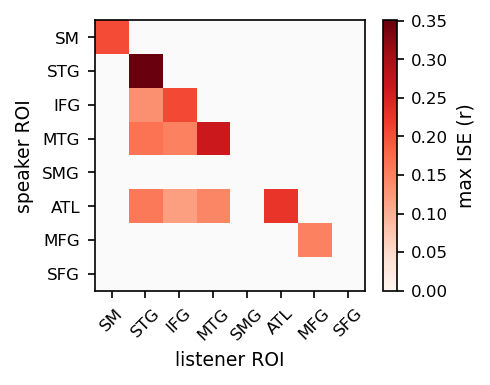

In [ ]:
# Plot roi x roi
w = 7.24 / 2 - 0.5
fig, ax = plt.subplots(figsize=(w, w * (3 / 4)))

palette = plt.cm.Reds.with_extremes(bad="#fafafa")

Mmax = Ml.max((2, 3))
Mmax.mask[np.triu_indices_from(Mmax, 1)] = True
print(Mmax.min(), Mmax.max())
im = ax.imshow(Mmax, cmap=palette, vmin=0)  # , vmax=mx)

# x, y = np.nonzero(sigs.any((2,3)))
# ax.scatter(y, x, marker='*', color='yellow', s=8)

ax.set(xlabel="listener ROI", ylabel="speaker ROI")
ax.set_xticks(range(len(rois)))
ax.set_yticks(range(len(rois)))
ax.set_xticklabels(rois, rotation=45)
ax.set_yticklabels(rois)
ax.spines.right.set_visible(True)
ax.spines.top.set_visible(True)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("max ISE (r)")
# cbar.set_ticks([0, mx])

fig.savefig(f"{outdir}/fig4_mode-lst_roisummary.svg")
plt.show()

/tmp/ipykernel_1251012/740426973.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[i, j])


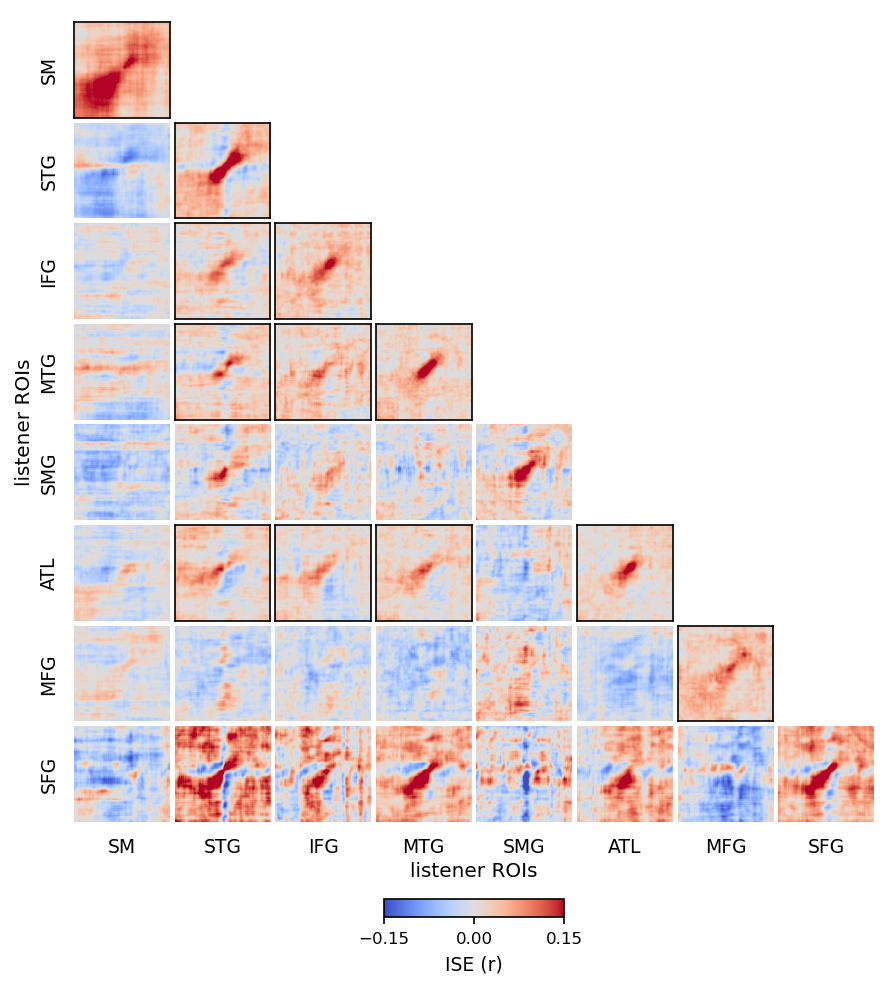

In [ ]:
# Plot all parcels within listener
mx = 0.15

nrow, ncol = 8, 8
fig, axes = plt.subplots(nrow, ncol, figsize=(6, 6))
gs = mpl.gridspec.GridSpec(
    nrow,
    ncol,
    wspace=0.05,
    hspace=0.05,
    top=1.0 - 0.5 / (nrow + 1),
    bottom=0.5 / (nrow + 1),
    left=0.5 / (ncol + 1),
    right=1 - 0.5 / (ncol + 1),
)

for i, roi1 in enumerate(rois):
    for j in range(i + 1, len(rois)):
        ax = axes[i, j]
        ax.spines.left.set_visible(False)
        ax.spines.bottom.set_visible(False)
        ax.set(xticks=[], yticks=[])

    for j in range(i + 1):
        rois2 = rois[j]
        ax = plt.subplot(gs[i, j])
        im = ax.matshow(
            Ml[i, j].data,
            origin="lower",
            interpolation=None,
            cmap="coolwarm",
            vmin=-mx,
            vmax=mx,
        )
        ax.set(xticks=[], yticks=[])
        if sigsL[i, j].any():
            ax.spines.right.set_visible(True)
            ax.spines.top.set_visible(True)
        else:
            ax.spines.left.set_visible(False)
            ax.spines.bottom.set_visible(False)
        if j == 0:
            ax.set_ylabel(rois[i])
        if i == nrow - 1:
            ax.set_xlabel(rois[j])

# cbar = fig.colorbar(im, ax=axes, shrink=0.5)
cax = plt.axes([0.4, -0.05, 0.2, 0.02])  # left, bottom, width, height
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_ticks([-mx, 0, mx])
cbar.set_label("ISE (r)")

fig.supylabel("listener ROIs", x=-0.01)
fig.supxlabel("listener ROIs", y=-0.01)

fig.savefig(f"{outdir}/fig4s_ise-full_mode-lst_roixroi.svg")
plt.show()

## interregional heatmaps

In [14]:
from util.plot import plot_outlines

In [11]:
fig4rois = [
    ("spk", "SM", "STG"),
    ("spklst", "SM", "STG"),
    ("spklst", "SM", "IFG"),
    ("lst", "STG", "IFG"),
    ("spk", "SM", "IFG"),
    ("spklst", "STG", "STG"),
    ("spklst", "ATL", "ATL"),
    ("lst", "STG", "ATL"),
]

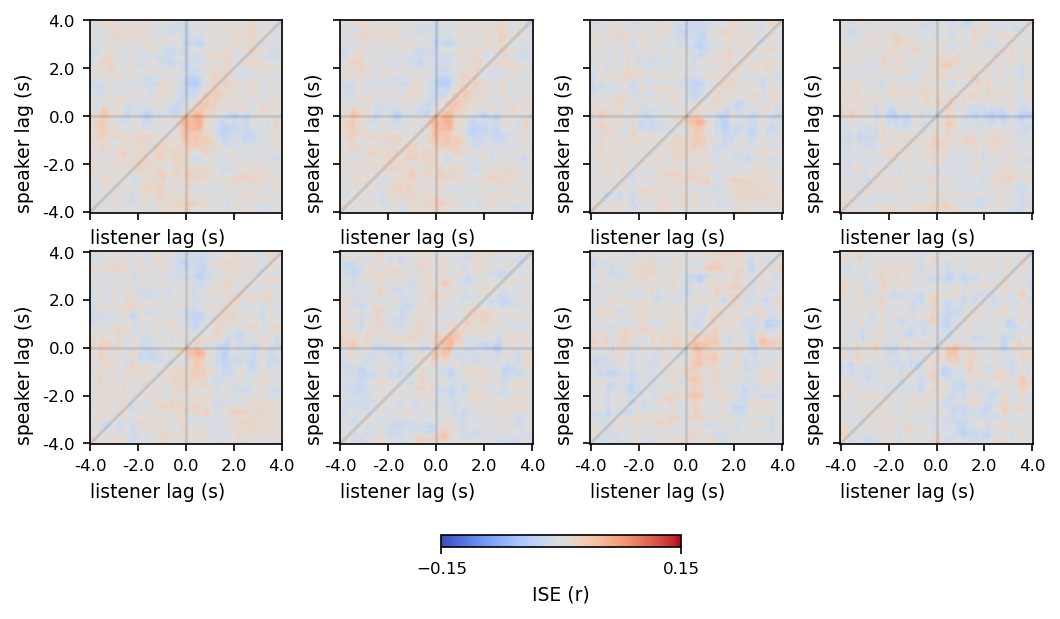

In [12]:
mx = 0.15

fig, axes = plt.subplots(2, 4, figsize=(8.25, 5.25), sharex=True, sharey=True)

for ax, (mode, roi1, roi2) in zip(axes.flatten(), fig4rois):
    i, j = rois.index(roi1), rois.index(roi2)

    heatmap = M
    xlabel = "listener lag (s)"
    ylabel = "speaker lag (s)"

    # if mode == 'spk':
    #     heatmap = Ms
    #     xlabel = 'speaker lag (s)'
    #     plot_outlines(sigsS_label[i, j].T, ax=ax, color='black', lw=0.5, ls='-', alpha=0.7, zorder=3)
    # elif mode == 'lst':
    #     heatmap = Ml
    #     ylabel = 'listener lag (s)'
    #     plot_outlines(sigsL_label[i, j].T, ax=ax, color='black', lw=0.5, ls='-', alpha=0.7, zorder=3)
    # else:
    #     plot_outlines(sigs_label[i, j].T, ax=ax, color='black', lw=0.5, ls='-', alpha=0.7, zorder=3)

    im = ax.imshow(
        heatmap[i, j].data,
        origin="lower",
        cmap="coolwarm",
        vmin=-mx,
        vmax=mx,
        aspect="equal",
    )
    formatim(fig, ax, im, lags, cbar_loc=None, xl=xlabel, yl=ylabel)
    # ax.text(0, .9, f'{roi1} | {roi2}', transform=ax.transAxes)
    ax.set_xlabel(xlabel, loc="left")
    ax.set_ylabel(ylabel, loc="bottom")

cbar = fig.colorbar(im, ax=axes, orientation="horizontal", shrink=0.25)
cbar.set_label("ISE (r)")
cbar.set_ticks([-mx, mx])

fig.savefig(f"{outdir}/fig4_heatmaps.svg")
plt.show()

0.09111194644144958 0.28010698848295906
0.11859337037106268 0.35030142609008735


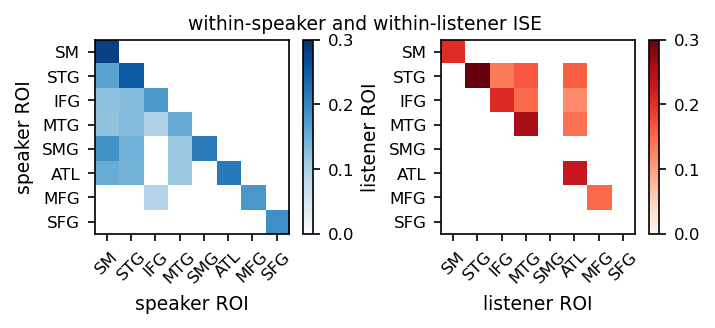

In [124]:
# plot roixroi spk-list together
w = 7.24 / 2 - 0.5
fig, axes = plt.subplots(1, 2, figsize=(w * 1.75, 1.68), sharex=True)

mx = 0.3

ax = axes[0]
Mmax = Ms.max((2, 3))
print(Mmax.min(), Mmax.max())
Mmax[np.triu_indices_from(Mmax, 1)] = np.nan
# mx = np.nanmax(Mmax)
im = ax.imshow(Mmax, cmap="Blues", vmin=0, vmax=mx)

ax.set(xlabel="speaker ROI", ylabel="speaker ROI")
ax.set_xticks(range(len(rois)))
ax.set_yticks(range(len(rois)))
ax.spines.right.set_visible(True)
ax.spines.top.set_visible(True)
ax.set_xticklabels(rois, rotation=45)
ax.set_yticklabels(rois)
fig.colorbar(im, ax=ax)

# x, y = np.nonzero(np.tril(sigsS.any((2, 3))))
# ax.scatter(y, x, marker='*', color='yellow', s=4)

# listener
ax = axes[1]
Mmax = Ml.max((2, 3))
print(Mmax.min(), Mmax.max())
Mmax[np.tril_indices_from(Mmax, -1)] = np.nan
# mx = np.nanmax(Mmax)
im = ax.imshow(Mmax, cmap="Reds", vmin=0, vmax=mx)

ax.set(xlabel="listener ROI", ylabel="listener ROI")
ax.set_xticks(range(len(rois)))
ax.set_yticks(range(len(rois)))
ax.spines.right.set_visible(True)
ax.spines.top.set_visible(True)
ax.set_xticklabels(rois, rotation=45)
ax.set_yticklabels(rois)
fig.colorbar(im, ax=ax)

# x, y = np.nonzero(np.triu(sigsL.any((2, 3))))
# ax.scatter(y, x, marker='*', color='yellow', s=4)

fig.suptitle("within-speaker and within-listener ISE")

fig.savefig(f"{outdir}/figS-ise-within-subjects.svg")
plt.show()

## single electrode pairs

In [98]:
from util.ise import getSubjectMap

(129, 129) 0.2737300390181958 1 1


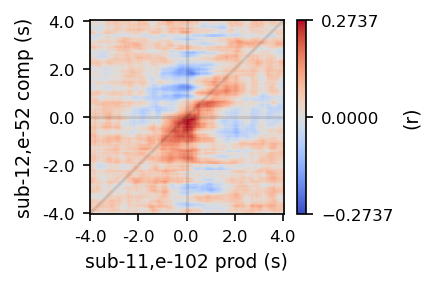

In [274]:
subA, subB = 12, 11

subA_sig = sigmasks[(subA, "prod")]
subA_elec = np.random.choice(*subA_sig.nonzero())

subB_sig = sigmasks[(subB, "comp")]
subB_elec = np.random.choice(*subB_sig.nonzero())

subA_sig = np.zeros_like(subA_sig)
subA_sig[subA_elec] = 1

subB_sig = np.zeros_like(subB_sig)
subB_sig[subB_elec] = 1

single_elecs = {
    (subA, "prod"): subA_sig,
    (subB, "comp"): subB_sig,
}

M, nS, nP = getSubjectMap(
    results, sub=subA, part=subB, modelname=modelname, significant=single_elecs
)
print(M.shape, M.max(), nS, nP)

mx = M.max()

fig, ax = plt.subplots(figsize=fs1c)
im = ax.imshow(
    M, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx
)
formatim(fig, ax, im, lags)
ax.set(
    xlabel=f"sub-{subB},e-{subB_elec} prod (s)",
    ylabel=f"sub-{subA},e-{subA_elec} comp (s)",
)

# fig.savefig(f'{outdir}/fig3-ise-all-small.svg')
plt.show()

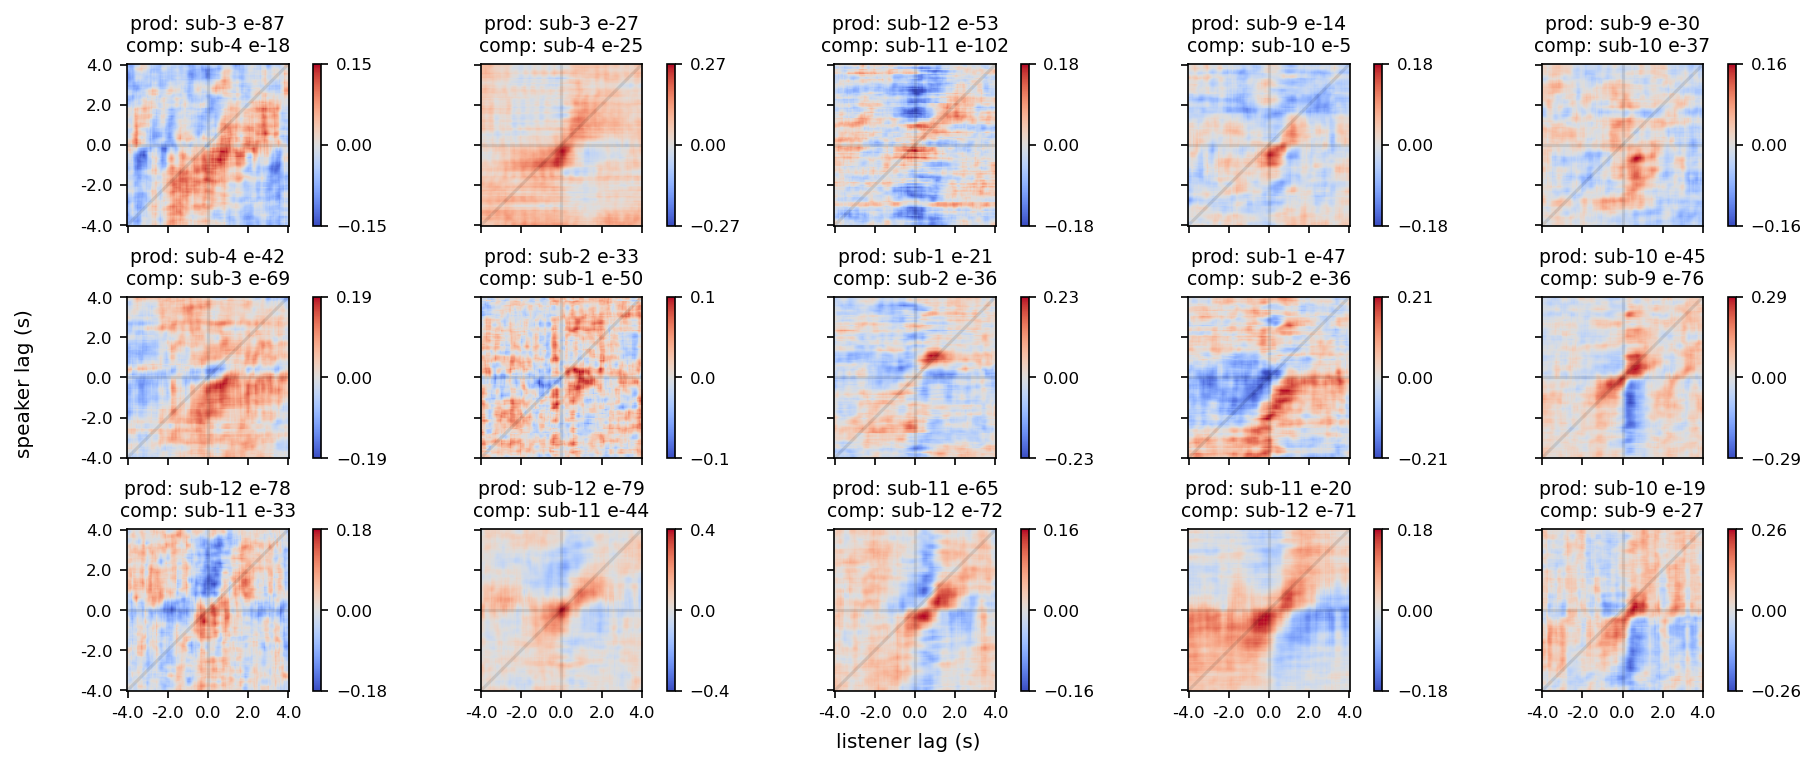

In [117]:
fig, axes = plt.subplots(
    3, 5, figsize=(12, 5), sharex=True, sharey=True, layout="constrained"
)

pairs = [
    (4, 3, 18, 87),
    (4, 3, 25, 27),
    (11, 12, 102, 53),
    (10, 9, 5, 14),
    (10, 9, 37, 30),
    (3, 4, 69, 42),
    (1, 2, 50, 33),
    (2, 1, 36, 21),
    (2, 1, 36, 47),
    (9, 10, 76, 45),
    (11, 12, 33, 78),
    (11, 12, 44, 79),
    (12, 11, 72, 65),
    (12, 11, 71, 20),
    (9, 10, 27, 19),
]

for ax, pair in zip(axes.ravel(), pairs):
    subA = pair[1]
    subB = pair[0]
    subA_elec = pair[3]
    subB_elec = pair[2]

    subA_sig = sigmasks[(subA, "prod")]
    subA_sig = np.zeros_like(subA_sig)
    subA_sig[subA_elec] = 1
    subB_sig = sigmasks[(subB, "comp")]
    subB_sig = np.zeros_like(subB_sig)
    subB_sig[subB_elec] = 1

    single_elecs = {
        (subA, "prod"): subA_sig,
        (subB, "comp"): subB_sig,
    }

    M, nS, nP = getSubjectMap(
        results, sub=subA, part=subB, modelname=modelname, significant=single_elecs
    )
    mx = np.round(M.max(), 2)
    im = ax.imshow(
        M, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx
    )
    cbar = formatim(
        fig,
        ax,
        im,
        lags,
        xl=None,
        yl=None,
        cl=None,
        title=f"prod: sub-{subA} e-{subA_elec}\ncomp: sub-{subB} e-{subB_elec}",
    )

fig.supylabel("speaker lag (s)")
fig.supxlabel("listener lag (s)")
fig.show()

## schematic figure

In [125]:
def rescale_col(df, col, vmin=0, vmax=1):
    x, y = df[col].min(), df[col].max()
    return (df[col] - x) / (y - x) * (vmax - vmin) + vmin

In [126]:
def color_col(df, cmap="Greys", vmin=None, vmax=None):
    vmin = df.min() if vmin is None else vmin
    vmax = df.max() if vmax is None else vmax
    colormap = mpl.cm.get_cmap(cmap)
    normer = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    return df.apply(lambda x: mpl.colors.to_hex(colormap(normer(x))))

In [127]:
maxesS = Ms.max((2, 3))
sumsS = sigsS.sum((2, 3))
anysigS = np.tril(sigsS.any((2, 3)), -1)
maxesP = Ml.max((2, 3))
sumsP = sigsL.sum((2, 3))
anysigP = np.tril(sigsL.any((2, 3)), -1)
maxesSP = M.max((2, 3))
anysigSP = sigs.any((2, 3))
sumsSP = sigs.sum((2, 3))

In [128]:
records = []
for i, j in zip(*anysigS.nonzero()):
    records.append(("spk-", rois[j], rois[i], maxesS[i, j], sumsS[i, j]))
for i, j in zip(*anysigP.nonzero()):
    records.append(("lst-", rois[j], rois[i], maxesP[i, j], sumsP[i, j]))
for i, j in zip(*anysigSP.nonzero()):
    records.append(("spklst-", rois[i], rois[j], maxesSP[i, j], sumsSP[i, j]))

In [139]:
mx = 0.15

df = pd.DataFrame(records, columns=("mode", "roi1", "roi2", "maxcorr", "npairs"))
df["label"] = df["mode"] + df["roi1"].str.lower() + "-" + df["roi2"].str.lower()

print(df.groupby("mode")["maxcorr"].max())

# df['stroke-width'] = rescale_col(df, 'npairs', 0.5, 1.8)
# df['stroke-opacity'] = rescale_col(df, 'maxcorr', 0.1, 1)
df["stroke"] = df["maxcorr"].to_frame().apply(color_col, vmin=0, vmax=mx)

# df['stroke'] = df.groupby('mode')['maxcorr'].transform(color_col, vmin=0, vmax=0.15, cmap='Greys')
df["stroke-width"] = 1

# save to file
dfj = df[["label", "stroke", "stroke-width"]].set_index("label")  # .to_dict('index')
dfj.to_json(f"{outdir}/fig5data.json", orient="index")

df

mode
lst-       0.164568
spk-       0.187518
spklst-    0.218484
Name: maxcorr, dtype: float64


mode roi1 roi2   maxcorr  npairs           label   stroke  stroke-width
0      spk-   SM  STG  0.165741     465      spk-sm-stg  #000000             1
1      spk-   SM  IFG  0.124239     848      spk-sm-ifg  #353535             1
2      spk-  STG  IFG  0.130032     740     spk-stg-ifg  #282828             1
3      spk-   SM  MTG  0.121039     550      spk-sm-mtg  #3d3d3d             1
4      spk-  STG  MTG  0.130089    1300     spk-stg-mtg  #272727             1
5      spk-  IFG  MTG  0.093035     816     spk-ifg-mtg  #757575             1
6      spk-   SM  SMG  0.187518    1122      spk-sm-smg  #000000             1
7      spk-  STG  SMG  0.144629      99     spk-stg-smg  #0a0a0a             1
8      spk-  MTG  SMG  0.114596      85     spk-mtg-smg  #4d4d4d             1
9      spk-   SM  ATL  0.151727    2314      spk-sm-atl  #000000             1
10     spk-  STG  ATL  0.143605     174     spk-stg-atl  #0c0c0c             1
11     spk-  MTG  ATL  0.114055     192     spk-mtg-atl  #4e4e4e             1
12     spk-  IFG  MFG  0.091112     104     spk-ifg-mfg  #787878             1
13     lst-  STG  IFG  0.133795     214     lst-stg-ifg  #1f1f1f             1
14     lst-  STG  MTG  0.164568     178     lst-stg-mtg  #000000             1
15     lst-  IFG  MTG  0.149220      98     lst-ifg-mtg  #010101             1
16     lst-  STG  ATL  0.158412     271     lst-stg-atl  #000000             1
17     lst-  IFG  ATL  0.118593      34     lst-ifg-atl  #434343             1
18     lst-  MTG  ATL  0.143813      79     lst-mtg-atl  #0c0c0c             1
19  spklst-   SM  STG  0.218484    1762   spklst-sm-stg  #000000             1
20  spklst-   SM  IFG  0.162715     814   spklst-sm-ifg  #000000             1
21  spklst-   SM  MTG  0.101527     114   spklst-sm-mtg  #656565             1
22  spklst-   SM  ATL  0.133935     608   spklst-sm-atl  #1f1f1f             1
23  spklst-  STG   SM  0.093120     810   spklst-stg-sm  #757575             1
24  spklst-  STG  STG  0.143331     397  spklst-stg-stg  #0d0d0d             1
25  spklst-  STG  ATL  0.104678     155  spklst-stg-atl  #606060             1
26  spklst-  IFG   SM  0.069466     157   spklst-ifg-sm  #a2a2a2             1
27  spklst-  IFG  STG  0.087200     138  spklst-ifg-stg  #7f7f7f             1
28  spklst-  IFG  MTG  0.113733      54  spklst-ifg-mtg  #4e4e4e             1
29  spklst-  IFG  ATL  0.097149     342  spklst-ifg-atl  #6d6d6d             1
30  spklst-  MTG   SM  0.079530     297   spklst-mtg-sm  #8e8e8e             1
31  spklst-  MTG  STG  0.094131     250  spklst-mtg-stg  #727272             1
32  spklst-  MTG  IFG  0.086617     140  spklst-mtg-ifg  #818181             1
33  spklst-  MTG  ATL  0.084508      58  spklst-mtg-atl  #848484             1
34  spklst-  SMG  STG  0.147363     287  spklst-smg-stg  #050505             1
35  spklst-  ATL  STG  0.144794     490  spklst-atl-stg  #090909             1
36  spklst-  ATL  ATL  0.095466     177  spklst-atl-atl  #707070             1
37  spklst-  MFG   SM  0.107949    1613   spklst-mfg-sm  #5a5a5a             1

In [141]:
!python svgtest.py ../results/figure5h.svg $outdir/fig5data.json $outdir/figure5h-mod.svg

Style not found for:  spklst-mtg-mtg
Style not found for:  spklst-mtg-sfg
Style not found for:  spklst-atl-ifg
Style not found for:  spklst-sfg-stg
Style not found for:  spklst-sfg-ifg
Style not found for:  spklst-smg-mfg
Style not found for:  spklst-mtg-mfg
Style not found for:  spklst-stg-ifg
Style not found for:  spklst-stg-mtg
Style not found for:  spklst-stg-sfg
Style not found for:  spk-sm-sfg
Style not found for:  spk-smg-atl
Style not found for:  spk-stg-mfg
Style not found for:  spk-mtg-sfg
Style not found for:  spk-ifg-sfg
Style not found for:  spk-atl-sfg
Style not found for:  spk-mtg-mfg
Style not found for:  spk-smg-sfg
Style not found for:  lst-smg-mfg
Style not found for:  lst-stg-sfg
Style not found for:  lst-mtg-sfg
Style not found for:  lst-stg-smg
Style not found for:  lst-atl-sfg
The following styles were not used:
set()


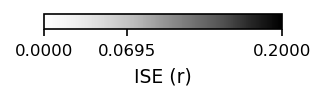

In [134]:
fig = plt.figure(figsize=(1.863, 0.284))
# The dimensions (left, bottom, width, height) of the new Axes. All quantities are in fractions of figure width and height.
ax = fig.add_axes([0, 1, 0.85, 0.35])
cb = mpl.colorbar.ColorbarBase(
    ax,
    orientation="horizontal",
    cmap=plt.get_cmap("Greys"),
    norm=mpl.colors.Normalize(vmin=0, vmax=mx),
)
cb.set_label("ISE (r)")
cb.set_ticks([0, df["maxcorr"].min(), mx])
fig.savefig(f"{outdir}/figS_colorbar25.svg")
plt.show()

## Figure S4.3 - s2l and l2s

0.13418265603460297
0.15931477362681695


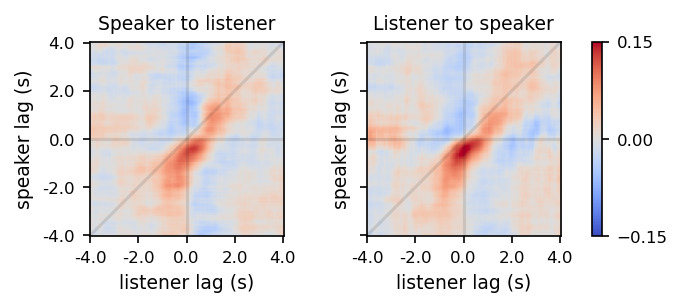

In [136]:
# All subjects
mx = 0.15

w = 7.24 / 2 - 0.5
fig, axes = plt.subplots(1, 2, figsize=(w * 1.75, 1.68), sharex=True, sharey=True)

ax = axes[0]
M, ns, ms = getMaps(
    results,
    Ss,
    modelname=modelname,
    significant=sigmasks,
    reduce=True,
    weight=True,
    mode="s2l",
)
im = ax.imshow(
    M, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(title="Speaker to listener")
print(M.max())

ax = axes[1]
M, ns, ms = getMaps(
    results,
    Ss,
    modelname=modelname,
    significant=sigmasks,
    reduce=True,
    weight=True,
    mode="l2s",
)
im = ax.imshow(
    M, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(title="Listener to speaker")
print(M.max())

cbar = fig.colorbar(im, ax=axes, orientation="vertical")
cbar.set_ticks([-mx, 0, mx])

fig.savefig(f"{outdir}/fig4s-s2l-l2s.svg")
plt.show()

# Significance tests

In [11]:
static = "model-gpt2-xl_maxlen-0_reg-l2"
contextual = "model-gpt2-xl_maxlen-1024_layer-24_reg-l2"
untrained = "model-gpt2-xl_maxlen-1024_layer-24_random_reg-l2"

symbolic = 'model-symbolic_reg-l2'
phonemic = 'model-phonetic_reg-l2'

In [21]:
# model comparison encoding within subject

sig = sigmasks
n_perms = 100000
model1 = contextual

for mode in modes:
    for model2 in [symbolic, phonemic]:
        MS, NS, _ = getMaps(results, Ss, modelname=model1, speakerROI=ALL_ROIs, partnerROI=ALL_ROIs, mode=f"within-{mode}", significant=sig, reduce=False, reduce_elecs=False)
        MP, _, NP = getMaps(results, Ss, modelname=model2, speakerROI=ALL_ROIs, partnerROI=ALL_ROIs, mode=f"within-{mode}", significant=sig, reduce=False, reduce_elecs=False)

        # Exclude all masked entries
        MS = MS[~MS.mask.any(-1)].data
        MP = MP[~MP.mask.any(-1)].data

        mag_permres = permutation_test(
            (MS, MP),
            statistic=mag_diff_statistic,
            vectorized=True,
            axis=0,
            permutation_type="independent",
            n_resamples=n_perms,
        )

        print(model2, mode, mag_permres.statistic, mag_permres.pvalue)

model-symbolic_reg-l2 prod 0.08982483 1.999980000199998e-05
model-phonetic_reg-l2 prod 0.09598145 1.999980000199998e-05
model-symbolic_reg-l2 comp 0.10909461 1.999980000199998e-05
model-phonetic_reg-l2 comp 0.1473729 1.999980000199998e-05


In [41]:
# model comparison MBC

method, alpha = "fdr_bh", 0.01
# outdir = f'../results/paper/{sigmodelname}_method-{method}_alpha-{alpha}/{modelname}'
sigmodelname = f"model-gpt2-xl_maxlen-0_reg-l2_perm-phase_method-{method}_alpha-{alpha}"

contextualM = np.load(f"../results/original-paper/{sigmodelname}/{contextual}/data-fig3-ise.npz")["observed"]
contextualM = contextualM.reshape(-1, 129, 129)

staticM = np.load(f"../results/original-paper/{sigmodelname}/{static}/data-fig3-ise.npz")["observed"]
staticM = staticM.reshape(-1, 129, 129)

symbolicM = np.load(f"../results/paper/{sigmodelname}/{symbolic}/data-fig3-ise.npz")["observed"]
symbolicM = symbolicM.reshape(-1, 129, 129)

phonemicM = np.load(f"../results/paper/{sigmodelname}/{phonemic}/data-fig3-ise.npz")["observed"]
phonemicM = phonemicM.reshape(-1, 129, 129)

In [43]:
# Build null distribution of differences

model1 = contextualM
model2 = symbolicM
model2 = phonemicM
model2 = staticM

difference = model1 - model2
observed = mean_diff_axis(difference)
null_distribution = permute_differences(
    difference, summary=mean_diff_axis, n_perms=10000
)

pvalues = calculate_pvalues(observed, null_distribution, alternative="two-sided")

method, alpha = "fdr_bh", 0.01
sigs, pvals_corr, alphacSidak, alphacBonf = multipletests(
    pvalues.flatten(), method=method, alpha=alpha
)
print(sigs.sum())

diff2 = np.ma.array(observed)
diff2.mask = ~sigs.reshape(129, 129)

diff = np.ma.array(observed)
diff.mask = ~sigs.reshape(129, 129)

1378


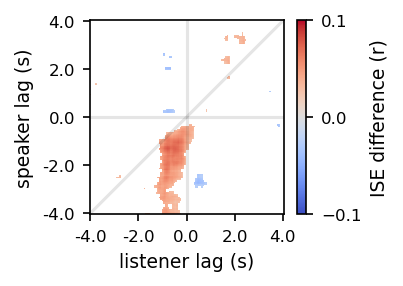

In [44]:
fig, ax = plt.subplots(figsize=fs1c)
im = plt.imshow(diff, origin="lower", cmap="coolwarm", vmin=-0.1, vmax=0.1)
formatim(fig, ax, im, lags, cbar_loc="v", cl="ISE difference (r)")
# fig.savefig(f"{outdir}/fig4s-model-compare-sigtest-contextual-symbolic.svg")
# fig.savefig(f"{outdir}/fig4s-model-compare-sigtest-contextual-phonemic.svg")
fig.savefig(f"{outdir}/fig4s-model-compare-sigtest-contextual-static.svg")
plt.show()

In [ ]:
# Load saved ISEs

method, alpha = "fdr_bh", 0.01
# outdir = f'../results/paper/{sigmodelname}_method-{method}_alpha-{alpha}/{modelname}'
sigmodelname = f"model-gpt2-xl_maxlen-0_reg-l2_perm-phase_method-{method}_alpha-{alpha}"

staticM = np.load(f"../results/paper/{sigmodelname}/{static}/data-fig3-ise.npz")[
    "observed"
]
contextualM = np.load(
    f"../results/paper/{sigmodelname}/{contextual}/data-fig3-ise.npz"
)["observed"]

untrainedM = np.load(f"../results/paper/{sigmodelname}/{untrained}/data-fig3-ise.npz")[
    "observed"
]
print(staticM.shape, contextualM.shape, untrainedM.shape)

staticM = staticM.reshape(-1, 129, 129)
contextualM = contextualM.reshape(-1, 129, 129)
untrainedM = untrainedM.reshape(-1, 129, 129)

In [ ]:
# Build null distribution of differences
difference = contextualM - staticM
# difference = contextualM - untrainedM
observed = mean_diff_axis(difference)
null_distribution = permute_differences(
    difference, summary=mean_diff_axis, n_perms=10000
)
difference.shape, observed.shape, null_distribution.shape

In [ ]:
pvalues = calculate_pvalues(observed, null_distribution, alternative="two-sided")
pvalues.shape

In [ ]:
method, alpha = "fdr_bh", 0.01
sigs, pvals_corr, alphacSidak, alphacBonf = multipletests(
    pvalues.flatten(), method=method, alpha=alpha
)
sigs.sum()

In [ ]:
diff2 = np.ma.array(observed)
diff2.mask = ~sigs.reshape(129, 129)

In [ ]:
diff = np.ma.array(observed)
diff.mask = ~sigs.reshape(129, 129)

fig, ax = plt.subplots()
im = plt.imshow(diff, origin="lower", cmap="coolwarm", vmin=-0.1, vmax=0.1)
formatim(fig, ax, im, lags, cbar_loc="v", cl="ISE (r)")
# fig.savefig(f'../results/paper/{contextual}/fig4s-contextual-static-sig-diff.svg')
fig.savefig(f"{outdir}/fig4s-contextual-untrained-sig-diff.svg")
plt.show()

In [ ]:
# significant differences
mx = 0.10

w = 7.24 / 2 - 0.5
fig, axes = plt.subplots(1, 2, figsize=(w * 1.75, 1.68), sharex=True, sharey=True)

ax = axes[0]
im = ax.imshow(
    diff, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(title="Trained vs. Untrained")

ax = axes[1]
im = ax.imshow(
    diff2, origin="lower", interpolation=None, cmap="coolwarm", vmin=-mx, vmax=mx
)
formatim(fig, ax, im, lags, cbar_loc=None)
ax.set(title="Contextual vs. Static")

cbar = fig.colorbar(im, ax=axes, orientation="vertical")
cbar.set_label("ISE (r)")

fig.savefig(f"{outdir}/fig4s-ise-sigtests.svg")
plt.show()

# Tables

In [7]:
# Load data
dfs = []
for (sub, mode, _), result in results.items():
    df = pd.DataFrame()
    df["electrode"] = result["electrodes"]
    df["roi"] = result["rois"]
    df["significant"] = sigmasks[(sub, mode)]
    df.insert(0, "mode", mode)
    df.insert(0, "subject", sub)
    dfs.append(df)

df = pd.concat(dfs)
roi2parcell = {roi: label for label, rois in ROIS.items() for roi in rois}
df["parcell"] = df.roi.apply(lambda x: roi2parcell.get(x, None))
df.dropna(inplace=True)
df

subject  mode       electrode   roi  significant parcell
0         1  prod   EEG GA_01-REF   RMF         True     MFG
1         1  prod   EEG GA_02-REF   RMF        False     MFG
2         1  prod   EEG GA_05-REF   RMF        False     MFG
3         1  prod   EEG GA_06-REF   CMF        False     MFG
4         1  prod   EEG GA_07-REF  PREC         True      SM
..      ...   ...             ...   ...          ...     ...
76       12  comp   EEG PT_03-REF  mMTG        False     MTG
77       12  comp   EEG PT_04-REF  mMTG        False     MTG
78       12  comp   EEG PT_05-REF  mSTG         True     STG
79       12  comp   EEG PT_06-REF  cSTG         True     STG
86       12  comp  EEG DAI_06-REF  POPE         True     IFG

[1410 rows x 6 columns]

In [8]:
# per- subject, mode, and ROI significant electrodes
col = "parcell"
mask = df.significant
dfcounts = (
    df[mask]
    .groupby(["subject", "mode", "parcell"])
    .electrode.count()
    .to_frame()
    .reset_index()
)
pd.pivot(dfcounts, index=["subject", "mode"], columns=[col]).fillna(0).astype(int)

electrode                            
parcell            ATL IFG MFG MTG SFG  SM SMG STG
subject mode                                      
1       comp         0   2   2   0   0   4   0   3
        prod         1   1   2   1   1   5   0   0
2       comp         1   0   0   1   0   1   0   5
        prod         2   3   2   5   0  11   4   9
3       comp         2   4   0   1   0   4   2   4
        prod         0   1   0   1   0   4   0   1
4       comp         1   5   1   1   0   2   0   9
        prod         3   6   1   5   0   6   2  11
5       comp         1   3   0   0   0   1   1   1
        prod         1   0   1   0   0   2   0   1
6       comp         0   0   0   0   0   0   0   2
        prod         5   1   0   1   0   7   0   6
9       comp         5   4   1   4   5   2   1   3
        prod         2   1   0   1   2   1   0   2
10      comp         3   0   2   3   5   4   0   0
        prod         2   0   1   4   2   7   0   1
11      comp         0   1   1   1   0   3   1   9
        prod        10   7   4   3   2  13   2  10
12      comp         1   4   1   0   0   1   0   4
        prod         0   2   2   1   0   2   2   4

In [9]:
# Cleaned up version of previous
mode = "prod"
mask = df.significant & (df["mode"] == mode)
dfcounts = (
    df[mask].groupby(["subject", "parcell"]).electrode.count().to_frame().reset_index()
)
df1 = pd.pivot(dfcounts, index="subject", columns=[col]).fillna(0).astype(int)
df1.insert(0, "mode", mode)

mode = "comp"
mask = df.significant & (df["mode"] == mode)
dfcounts = (
    df[mask].groupby(["subject", "parcell"]).electrode.count().to_frame().reset_index()
)
df2 = pd.pivot(dfcounts, index="subject", columns=[col]).fillna(0).astype(int)
df2.insert(0, "mode", mode)

df3 = pd.concat((df1, df2))
df3.loc["Column_Total"] = df3.sum(numeric_only=True, axis=0).astype(int)
df3.loc[:, "Row_Total"] = df3.sum(numeric_only=True, axis=1).astype(int)

del df1, df2
df3 = df3.astype(int, errors="ignore")
df3

mode electrode                             Row_Total
parcell                  ATL IFG MFG MTG SFG  SM SMG STG          
subject                                                           
1             prod         1   1   2   1   1   5   0   0        11
2             prod         2   3   2   5   0  11   4   9        36
3             prod         0   1   0   1   0   4   0   1         7
4             prod         3   6   1   5   0   6   2  11        34
5             prod         1   0   1   0   0   2   0   1         5
6             prod         5   1   0   1   0   7   0   6        20
9             prod         2   1   0   1   2   1   0   2         9
10            prod         2   0   1   4   2   7   0   1        17
11            prod        10   7   4   3   2  13   2  10        51
12            prod         0   2   2   1   0   2   2   4        13
1             comp         0   2   2   0   0   4   0   3        11
2             comp         1   0   0   1   0   1   0   5         8
3             comp         2   4   0   1   0   4   2   4        17
4             comp         1   5   1   1   0   2   0   9        19
5             comp         1   3   0   0   0   1   1   1         7
6             comp         0   0   0   0   0   0   0   2         2
9             comp         5   4   1   4   5   2   1   3        25
10            comp         3   0   2   3   5   4   0   0        17
11            comp         0   1   1   1   0   3   1   9        16
12            comp         1   4   1   0   0   1   0   4        11
Column_Total   NaN        40  45  21  33  17  80  15  85       336

In [35]:
# How many electrodes are significant for comp/prod?
df2 = (
    df.groupby(["subject", "electrode", "mode"], sort=False)
    .significant.sum()
    .unstack("mode")
)
df2["both"] = df2["comp"] & df2["prod"]
df2["only_comp"] = df2["comp"] & (~df2["prod"])
df2["only_prod"] = df2["prod"] & (~df2["comp"])
df2.sum()

mode
prod         203
comp         133
both          69
only_comp     64
only_prod    134
dtype: int64

In [42]:
df3 = df2.reset_index()
df3[df3.subject == 1]

mode  subject        electrode  prod  comp  both  only_comp  only_prod
0           1    EEG GA_01-REF     1     0     0          0          1
1           1    EEG GA_02-REF     0     0     0          0          0
2           1    EEG GA_05-REF     0     0     0          0          0
3           1    EEG GA_06-REF     0     0     0          0          0
4           1    EEG GA_07-REF     1     1     1          0          0
..        ...              ...   ...   ...   ...        ...        ...
69          1  EEG DPSI_04-REF     0     0     0          0          0
70          1   EEG DAH_04-REF     0     0     0          0          0
71          1   EEG DPH_02-REF     0     0     0          0          0
72          1   EEG DPH_03-REF     0     0     0          0          0
73          1   EEG DPH_04-REF     0     0     0          0          0

[74 rows x 7 columns]

In [88]:
coords = []
values = []

for sub in Ss:
    maskP = sigmasks[(sub, "prod")]
    maskC = sigmasks[(sub, "comp")]
    onlyP = maskP & (~maskC)
    onlyC = maskC & (~maskP)
    both = maskP & maskC
    # print(both.sum(), onlyP.sum(), onlyC.sum(), maskP.sum(), maskC.sum())
    # print((onlyP & onlyC).any(), (both & onlyP).any(), (both & onlyC).any())

    mask = both | onlyP | onlyC
    coords.append(allcoords[sub][mask].squeeze())

    vals = np.zeros_like(maskP, dtype=np.int8)
    vals[onlyP] = 0
    vals[onlyC] = 3
    vals[both] = 4
    values.append(vals[mask])

values = np.concatenate(values)
coords = np.vstack(coords)
np.unique(values, return_counts=True)

(array([0, 3, 4], dtype=int8), array([151,  83,  75]))

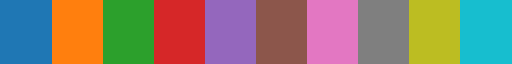

In [79]:
plt.get_cmap("tab10")

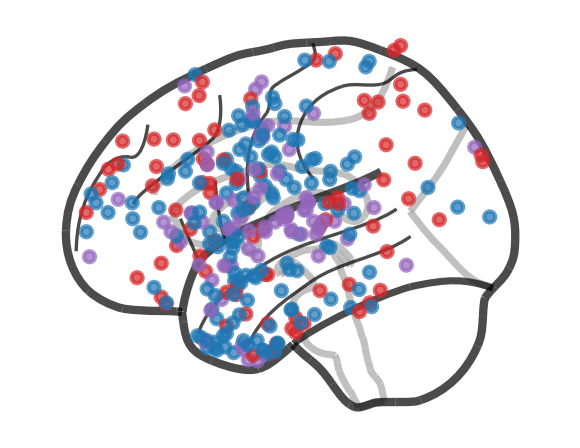

In [96]:
fig, ax = plt.subplots(dpi=300)
plot_markers(
    values,
    coords,
    display_mode="l",
    figure=fig,
    axes=ax,
    node_vmax=10,
    node_vmin=0,
    node_size=7,
    alpha=0.7,  # node_kwargs=dict(edgecolor='k'),
    colorbar=False,
    node_cmap="tab10",
)
fig.show()

In [59]:
dft[dft.any(1)].sum()

0    11
1    12
2     6
3     7
4     5
dtype: int64

In [33]:
# Load data
records = []
for (sub, mode, _), result in results.items():
    roilist = sum([list(v) for v in ROIS.values()], [])
    roimask = np.in1d(result["rois"], roilist)
    sig_elecs = np.array(result["electrodes"])[sigmasks[(sub, mode)] & roimask]
    n_depth = sum([e[4:].startswith("D") for e in sig_elecs])
    n_grid = sum([e[4:].startswith("G") for e in sig_elecs])
    n_strip = len(sig_elecs) - n_depth - n_grid
    records.append((sub, mode, len(sig_elecs), n_grid, n_strip, n_depth))

df_etype = pd.DataFrame(
    records, columns=["sub", "mode", "all", "grid", "strip", "depth"]
)
df_etype.loc["Column_Total"] = df_etype.sum(numeric_only=True, axis=0).astype(int)
df_etype.loc[:, "Row_Total"] = df_etype.sum(numeric_only=True, axis=1).astype(int)
df_etype

sub  mode    all   grid  strip  depth  Row_Total
0               1.0  prod   11.0    9.0    2.0    0.0         23
1               1.0  comp   11.0   11.0    0.0    0.0         23
2               2.0  prod   36.0   34.0    2.0    0.0         74
3               2.0  comp    8.0    7.0    1.0    0.0         18
4               3.0  prod    7.0    6.0    0.0    1.0         17
5               3.0  comp   17.0    9.0    3.0    5.0         37
6               4.0  prod   34.0   27.0    4.0    3.0         72
7               4.0  comp   19.0   17.0    2.0    0.0         42
8               5.0  prod    5.0    4.0    1.0    0.0         15
9               5.0  comp    7.0    6.0    1.0    0.0         19
10              6.0  prod   20.0   16.0    4.0    0.0         46
11              6.0  comp    2.0    2.0    0.0    0.0         10
12              9.0  prod    9.0    4.0    4.0    1.0         27
13              9.0  comp   25.0   19.0    6.0    0.0         59
14             10.0  prod   17.0    0.0   17.0    0.0         44
15             10.0  comp   17.0    0.0   17.0    0.0         44
16             11.0  prod   51.0   34.0   11.0    6.0        113
17             11.0  comp   16.0   15.0    0.0    1.0         43
18             12.0  prod   13.0    6.0    7.0    0.0         38
19             12.0  comp   11.0    5.0    5.0    1.0         34
Column_Total  126.0   NaN  336.0  231.0   87.0   18.0        798

# Fig SX

In [ ]:
# Mock data
from utils import epochbin

data = np.zeros(10 * 512).reshape(-1, 1)
tmax, window, jump = 4 * 512, 0.250 * 512, 0.0625 * 512
lags = np.arange(-tmax, tmax + jump, jump).astype(int)
onsets = [5 * 512]
data[onsets, :] = 1
S = epochbin(data, onsets, lags, int(window)).squeeze()
S /= S.sum()
S.shape

In [ ]:
MS, NS, _ = getMaps(
    results,
    Ss,
    modelname=modelname,
    speakerROI=ALL_ROIs,
    partnerROI=ALL_ROIs,
    mode="within-prod",
    significant=sig,
    reduce=True,
)
MP, _, NP = getMaps(
    results,
    Ss,
    modelname=modelname,
    speakerROI=ALL_ROIs,
    partnerROI=ALL_ROIs,
    mode="within-comp",
    significant=sig,
    reduce=True,
)

In [ ]:
fsh = 2.24 * (3 / 4)
fs2c = (4.76, fsh)
xaxis = lags / 512

fig, axes = plt.subplots(1, 2, figsize=fs2c)

ax = axes[0]
ax.plot(xaxis, S, color="black")
ax.plot(xaxis, MS, color=BLUE)
ax.plot(xaxis, MP, color=RED)
# ax.set_xlim(-1, 1)
ax.set(xlabel="lag (s)", ylabel="encoding (r)")
formatenc(ax)

ax = axes[1]
im = ax.imshow(np.outer(S, S), cmap="Greys", origin="lower")
formatim(fig, ax, im, xaxis, cbar_loc=None)
plt.show()